## Previsão de temperatura média em Belém, Pará, Brasil

In [1]:
# pip install tensorflow
# pip install scikit-posthocs
# pip install numpy==1.24.0

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Filtragem do dataset

In [3]:
# dataset com todas as estações do Brasil
df_all = pd.read_csv('data/BrazilWeather/weather_sum_combinado.csv')

In [4]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1858839 entries, 0 to 1858838
Data columns (total 11 columns):
 #   Column             Dtype  
---  ------             -----  
 0   ESTACAO            object 
 1   DATA (YYYY-MM-DD)  object 
 2   rain_max           float64
 3   rad_max            float64
 4   temp_avg           float64
 5   temp_max           float64
 6   temp_min           float64
 7   hum_max            float64
 8   hum_min            float64
 9   wind_max           float64
 10  wind_avg           float64
dtypes: float64(9), object(2)
memory usage: 156.0+ MB


Filtrando dados somente da cidade de Belém:

In [5]:
weather_df = df_all[df_all['ESTACAO'] == 'A201'].copy()

In [6]:
weather_df.head()

ESTACAO DATA (YYYY-MM-DD)  rain_max  rad_max   temp_avg  temp_max  \
83021    A201        2014-01-01       0.0   3245.0  27.458333      33.9   
83022    A201        2014-01-02       2.0   2734.1  27.654167      33.5   
83023    A201        2014-01-03       0.0   2998.8  27.670833      33.6   
83024    A201        2014-01-04       5.2   3171.7  26.179167      33.6   
83025    A201        2014-01-05      10.8   3015.3  26.191667      32.6   

       temp_min  hum_max  hum_min  wind_max  wind_avg  
83021      23.2     92.0     46.0       7.7  1.437500  
83022      24.8     87.0     51.0       6.5  1.041667  
83023      23.3     92.0     44.0       6.8  1.116667  
83024      23.7     93.0     49.0       6.1  0.975000  
83025      22.6     93.0     53.0       8.3  1.141667

# Pré-processamento

* Extrair características da data

In [7]:
weather_df['DATA (YYYY-MM-DD)'] = pd.to_datetime(weather_df['DATA (YYYY-MM-DD)'])

In [8]:
# Extrair características da data
weather_df.loc[:, 'ano'] = weather_df['DATA (YYYY-MM-DD)'].dt.year
weather_df.loc[:, 'mes'] = weather_df['DATA (YYYY-MM-DD)'].dt.month
weather_df.loc[:, 'dia'] = weather_df['DATA (YYYY-MM-DD)'].dt.day
# weather_df.loc[:, 'dia_da_semana'] = weather_df['DATA (YYYY-MM-DD)'].dt.dayofweek  # segunda = 0, domingo = 6


In [9]:
weather_df['ano'].value_counts()

2016    366
2015    365
2018    365
2019    365
2023    365
2014    364
2017    364
2021    363
2022    356
2020    353
2024    244
Name: ano, dtype: int64

In [10]:
weather_df['mes'].value_counts()

5     341
7     341
8     341
1     340
4     329
3     327
6     321
2     311
10    310
12    310
11    300
9     299
Name: mes, dtype: int64

* Verificar valores ausentes

In [11]:
print("Valores ausentes por coluna:")
print(weather_df.isnull().sum())

Valores ausentes por coluna:
ESTACAO               0
DATA (YYYY-MM-DD)     0
rain_max              0
rad_max              19
temp_avg              0
temp_max              0
temp_min              0
hum_max               0
hum_min               0
wind_max             74
wind_avg             74
ano                   0
mes                   0
dia                   0
dtype: int64


Interpolação

In [12]:
numeric_columns = weather_df.select_dtypes(include=['float64', 'int64'])
weather_df[numeric_columns.columns] = numeric_columns.interpolate(method='linear', inplace=False)

In [13]:
# # Calcular a matriz de correlação
# correlation_matrix = weather_df[['rain_max', 'rad_max', 'temp_avg', 'temp_max', 'temp_min', 'hum_max', 'hum_min', 'wind_max', 'wind_avg']].corr()

# plt.figure(figsize=(12, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
# plt.title('Matriz de Correlação entre Variáveis Meteorológicas')
# plt.show()

Temperatura Média (°C) por mês

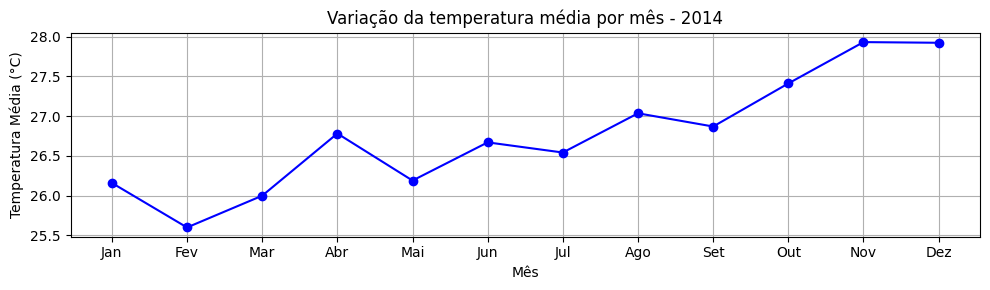

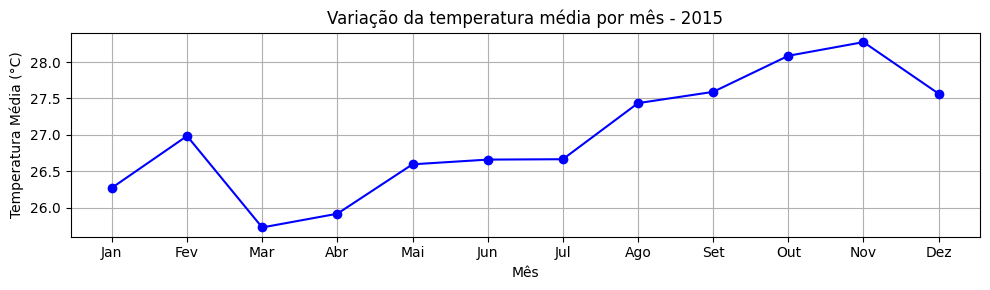

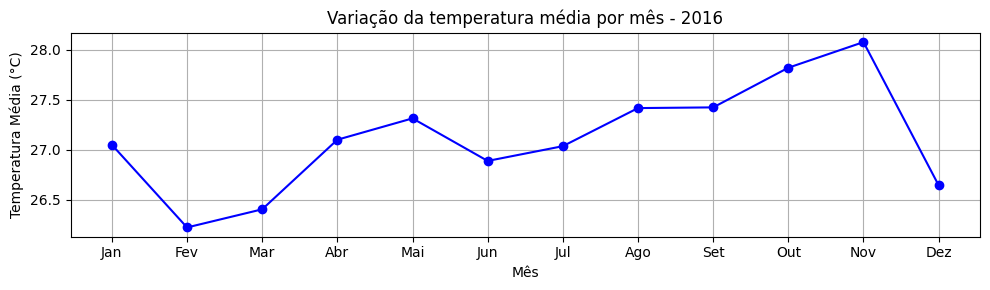

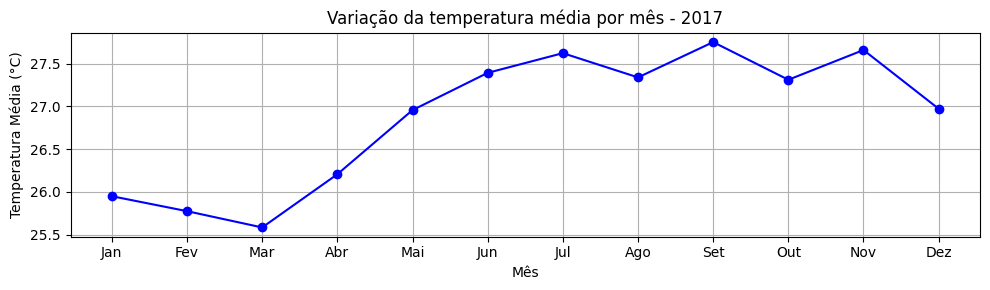

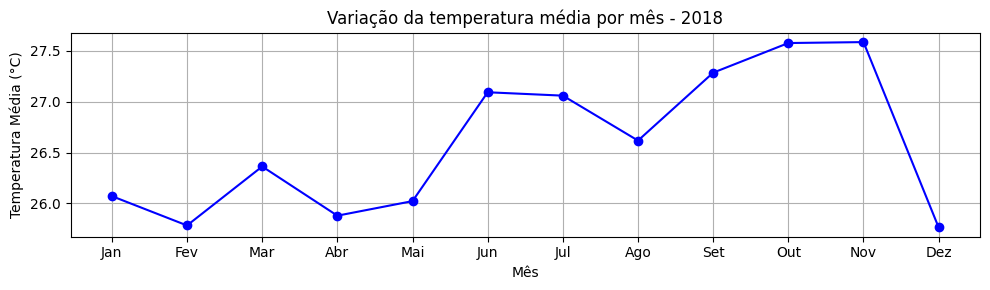

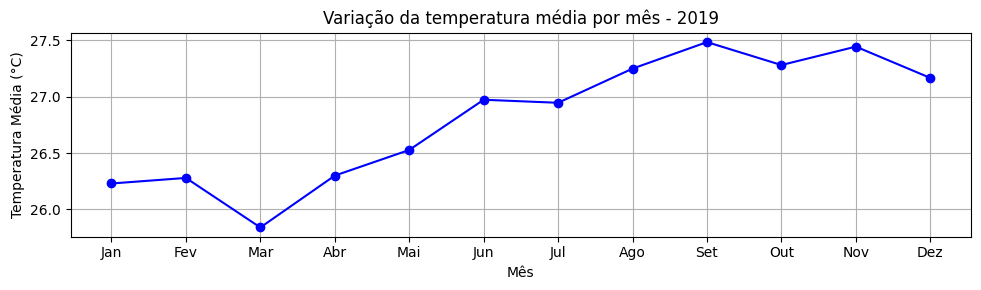

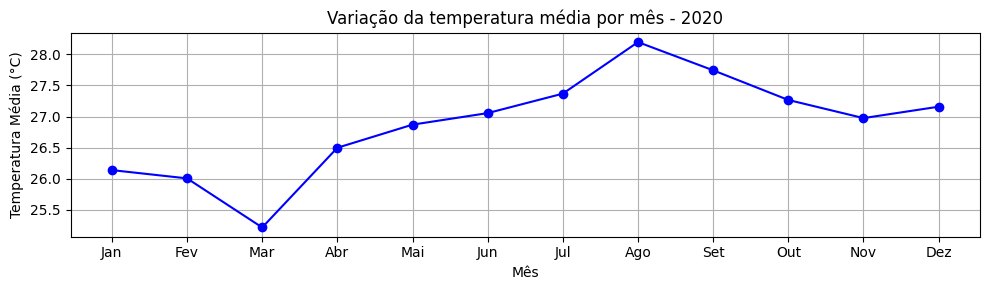

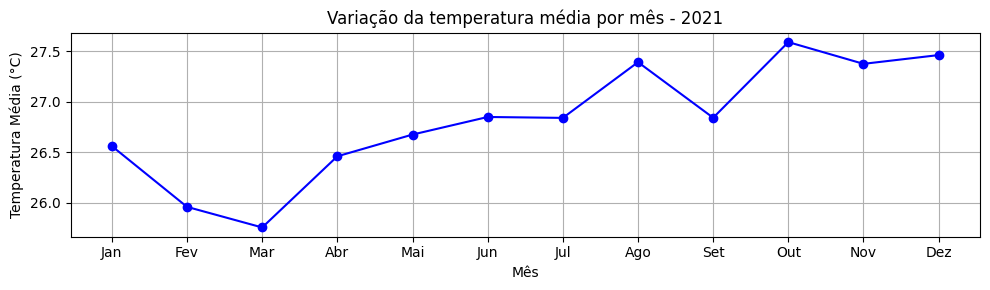

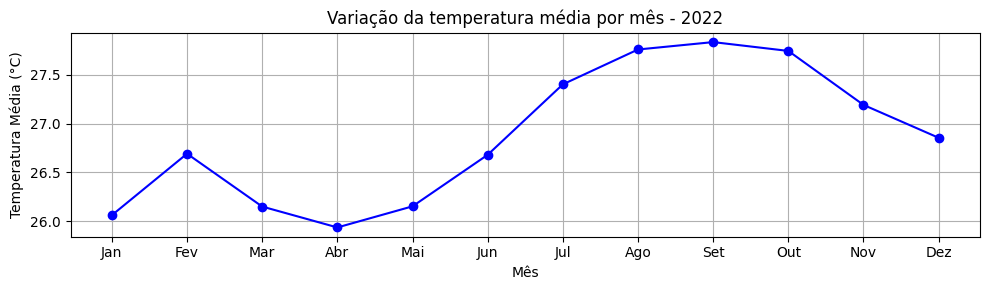

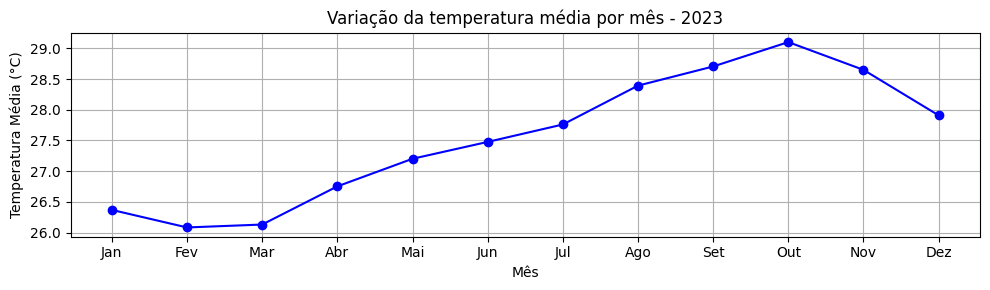

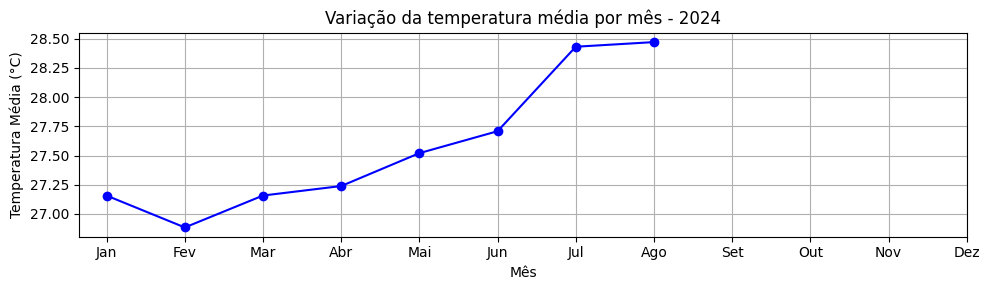

In [14]:
anos = weather_df['ano'].unique()
for ano in anos:
    plt.figure(figsize=(10, 3))
    dados_ano = weather_df[weather_df['ano'] == ano]
    dados_mes = dados_ano.groupby('mes')['temp_avg'].mean()
    
    plt.plot(dados_mes.index, dados_mes.values, label=f'Temperatura Média - {ano}', color='b', marker='o')
    plt.xlabel('Mês')
    plt.ylabel('Temperatura Média (°C)')
    plt.title(f'Variação da temperatura média por mês - {ano}')
    plt.grid(True)
    plt.xticks(ticks=range(1, 13), labels=['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
    plt.tight_layout()
    plt.show()

## Seleção de variáveis

In [15]:
features = ['rain_max', 'rad_max', 'temp_max', 'temp_min', 
            'hum_max', 'hum_min', 'wind_max', 'wind_avg', 'ano', 'mes']
target = ['temp_avg']

## Normalização

In [16]:
# Normalização geral dos dados
scaler = MinMaxScaler(feature_range=(0, 1))
X_weather_scaled = scaler.fit_transform(weather_df[features].values)

In [17]:
target_scaler = MinMaxScaler()
y_weather_scaled = target_scaler.fit_transform(weather_df[target].values)

### Validação Cruzada

In [18]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

In [19]:
time_steps = 30  # Tamanho das sequências temporais

def create_sequences(features, target, time_steps=30):
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features[i:(i + time_steps)])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

In [20]:
# n_years = 10  # número total de anos nos dados
# n_splits = 5  # número de divisões
# test_size = 365  # tamanho do conjunto de teste (1 ano)

# tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)

In [21]:
# # Imprimir informações detalhadas sobre cada divisão
# for fold, (train_index, test_index) in enumerate(tscv.split(weather_df)):
#     train_start = weather_df['DATA (YYYY-MM-DD)'].iloc[train_index[0]]
#     train_end = weather_df['DATA (YYYY-MM-DD)'].iloc[train_index[-1]]
#     test_start = weather_df['DATA (YYYY-MM-DD)'].iloc[test_index[0]]
#     test_end = weather_df['DATA (YYYY-MM-DD)'].iloc[test_index[-1]]
    
#     print(f"\nDivisão {fold + 1}:")
#     print(f"Treino: {train_start.date()} até {train_end.date()} ({len(train_index)} dias)")
#     print(f"Teste:  {test_start.date()} até {test_end.date()} ({len(test_index)} dias)")

# Arquiteturas 

In [22]:
from tensorflow.keras.layers import Dropout, BatchNormalization

def create_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(100, input_shape=input_shape, return_sequences=True))  
    model.add(Dropout(0.2))  # Dropout reduzido
    model.add(LSTM(50, return_sequences=False))  
    model.add(Dense(25, activation='relu')) 
    model.add(Dense(1))  # Saída única
    return model

def create_bilstm(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(100, return_sequences=True), input_shape=input_shape)) 
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(50, return_sequences=False)))  
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1))
    return model

def create_gru(input_shape):
    model = Sequential()
    model.add(GRU(100, input_shape=input_shape, return_sequences=True)) 
    model.add(Dropout(0.2))
    model.add(GRU(50, return_sequences=False))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1))
    return model

In [23]:
results = {'LSTM': [], 'BiLSTM': [], 'GRU': []}

In [24]:
model_creators = {'LSTM': create_lstm, 'BiLSTM': create_bilstm, 'GRU': create_gru}

In [25]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

detailed_results = {}

for fold, (train_index, test_index) in enumerate(tscv.split(X_weather_scaled)):
    # treino e teste
    train_features, test_features = X_weather_scaled[train_index], X_weather_scaled[test_index]
    train_target, test_target = y_weather_scaled[train_index], y_weather_scaled[test_index]

    # sequências temporais para treino e teste
    X_train, y_train = create_sequences(train_features, train_target, time_steps)
    X_test, y_test = create_sequences(test_features, test_target, time_steps)

    # dimensões para entrada nos modelos
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], len(features))
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], len(features))

    # modelos para cada fold
    for model_name, create_model in zip(['LSTM', 'BiLSTM', 'GRU'], [create_lstm, create_bilstm, create_gru]):
        print(f"\nTreinando modelo {model_name} no fold {fold + 1}...")

        
        model = create_model((X_train.shape[1], X_train.shape[2]))
        optimizer = Adam(learning_rate=0.005)  
        model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse', 'mae'])

       
        history = model.fit(
            X_train, y_train,
            validation_split=0.2,
            epochs=150,  
            batch_size=64, 
            verbose=1,
            callbacks=[early_stopping]
        )

        y_pred = model.predict(X_test).flatten()

        # métricas
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        if model_name not in detailed_results:
            detailed_results[model_name] = []

        detailed_results[model_name].append({
            'fold': fold + 1,
            'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2,
            'y_test': y_test, 'y_pred': y_pred,
            'history': history.history
        })

        print(f"{model_name} - Fold {fold + 1}:")
        print(f"MSE={mse:.4f}, RMSE={rmse:.4f}, MAE={mae:.4f}, R2={r2:.4f}")


Treinando modelo LSTM no fold 1...

Epoch 1/150


8/8 [==============================] - 5s 163ms/step - loss: 0.1259 - mse: 0.1259 - mae: 0.2588 - val_loss: 0.0356 - val_mse: 0.0356 - val_mae: 0.1852
Epoch 2/150
8/8 [==============================] - 0s 41ms/step - loss: 0.0128 - mse: 0.0128 - mae: 0.0937 - val_loss: 0.0144 - val_mse: 0.0144 - val_mae: 0.1150
Epoch 3/150
8/8 [==============================] - 0s 52ms/step - loss: 0.0067 - mse: 0.0067 - mae: 0.0678 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0313
Epoch 4/150
8/8 [==============================] - 0s 58ms/step - loss: 0.0038 - mse: 0.0038 - mae: 0.0485 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0255
Epoch 5/150
8/8 [==============================] - 0s 48ms/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0407 - val_loss: 0.0032 - val_mse: 0.0032 - val_mae: 0.0500
Epoch 6/150
8/8 [==============================] - 0s 46ms/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0382 - val_loss: 9.0336e-04 - val_mse: 9.0336e-0

In [32]:
import pickle

# Salvar
with open('results_dictionary.pkl', 'wb') as f:
    pickle.dump(results, f)

In [52]:
# # Carregar
with open('results_dictionary.pkl', 'rb') as f:
    results = pickle.load(f)

# Resultados

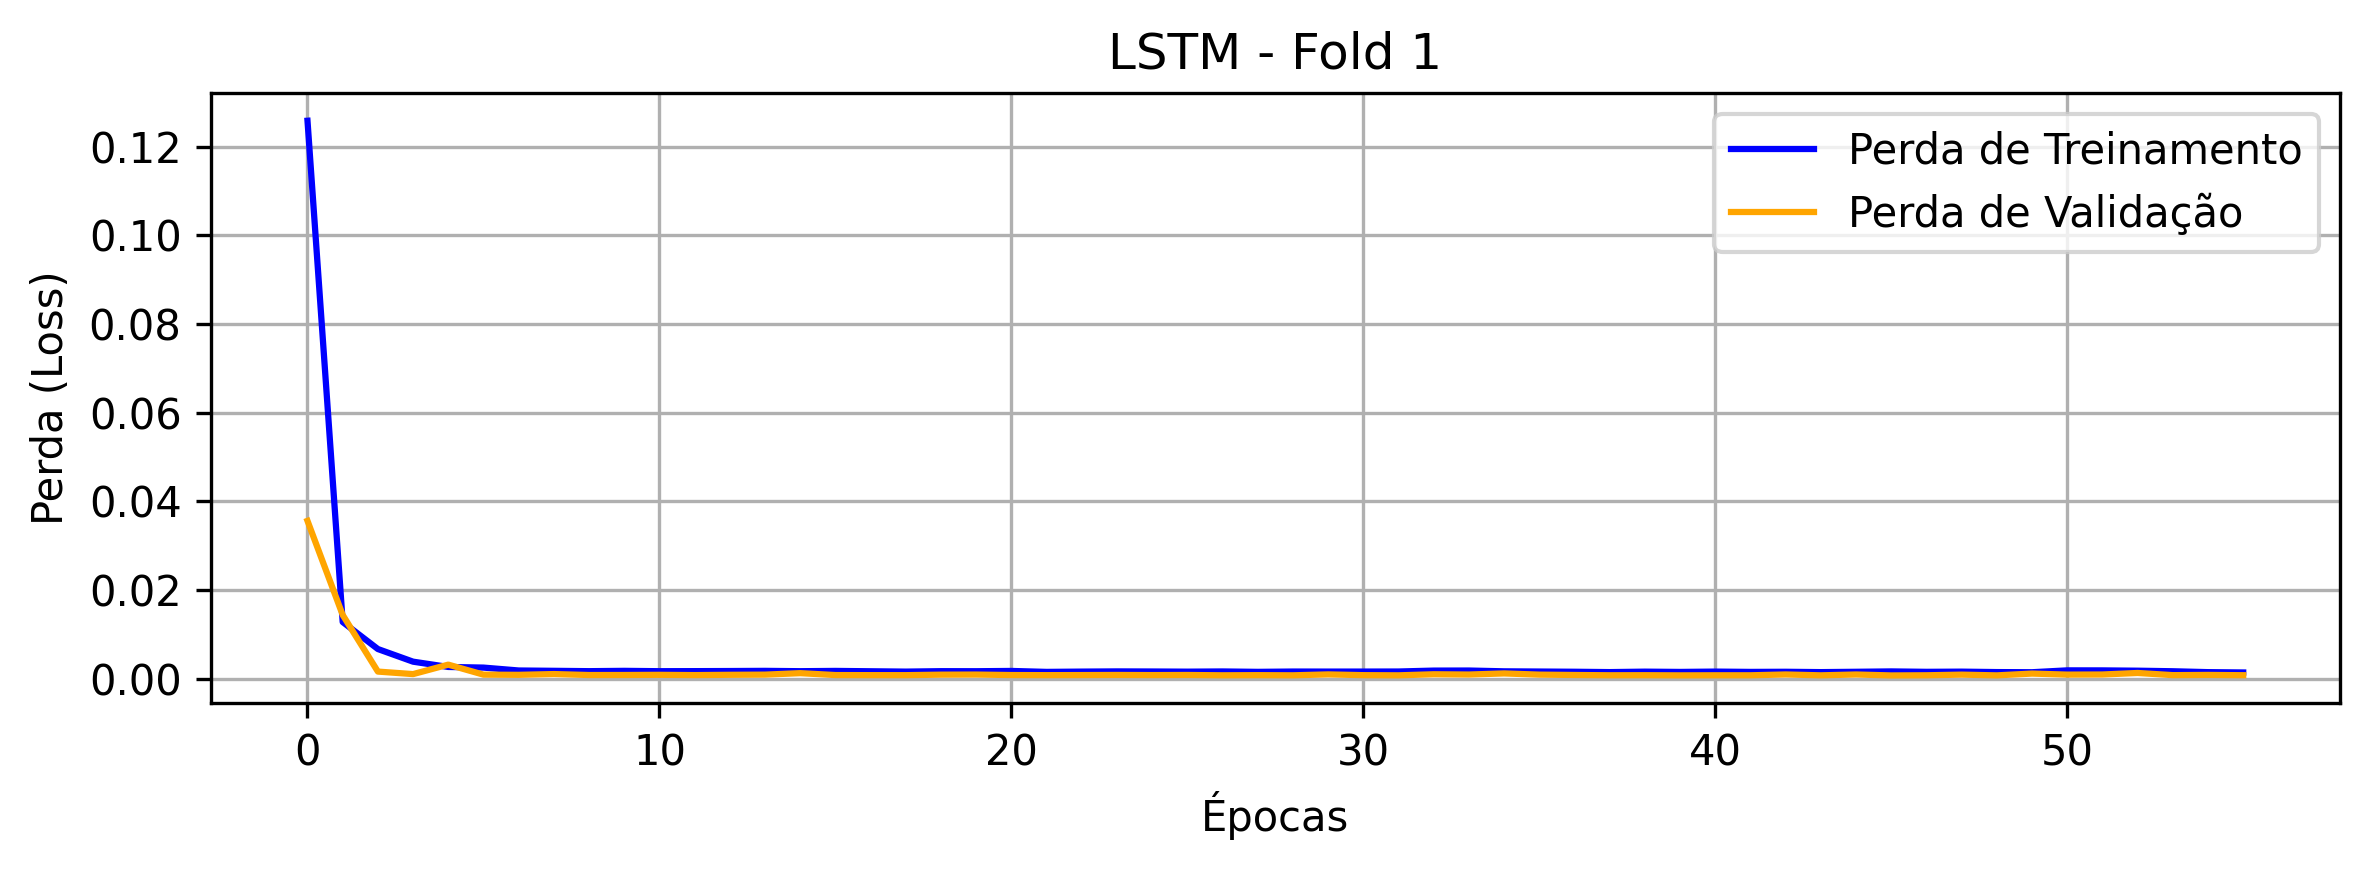

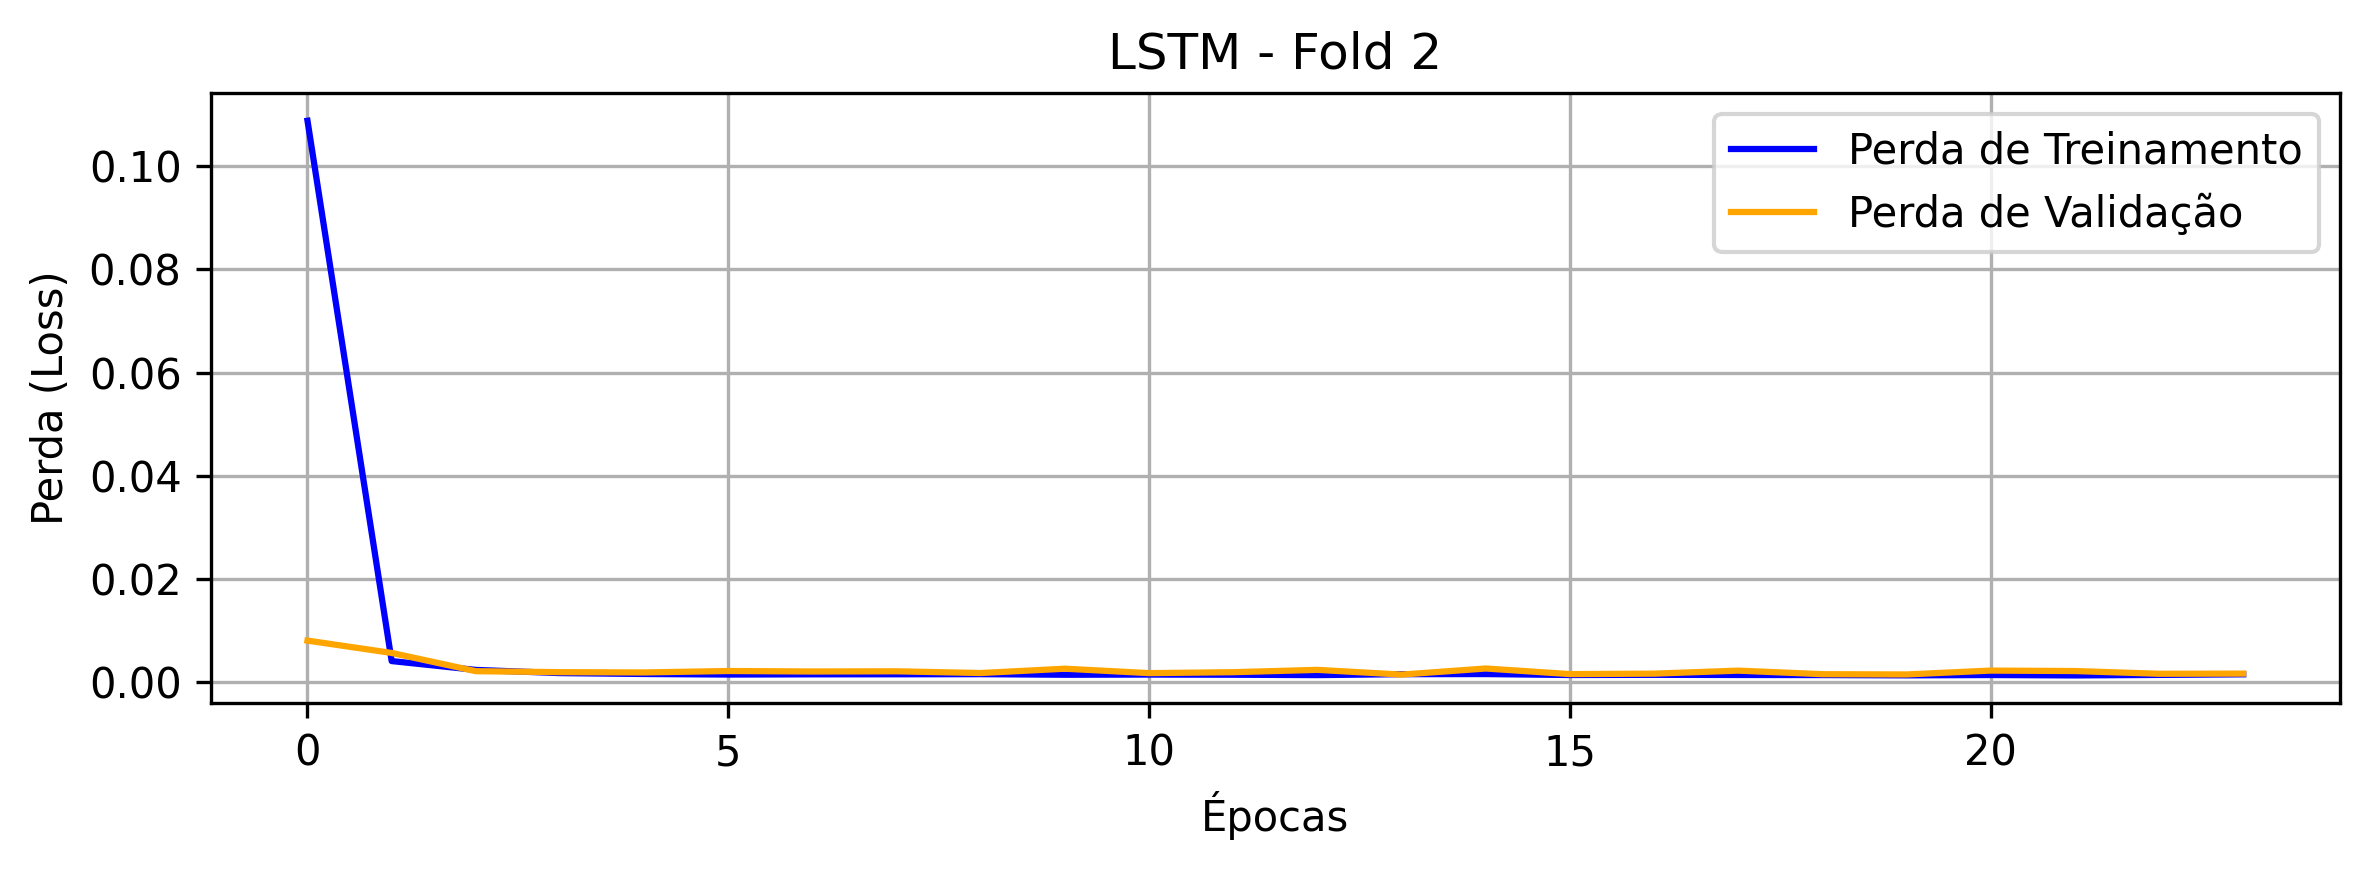

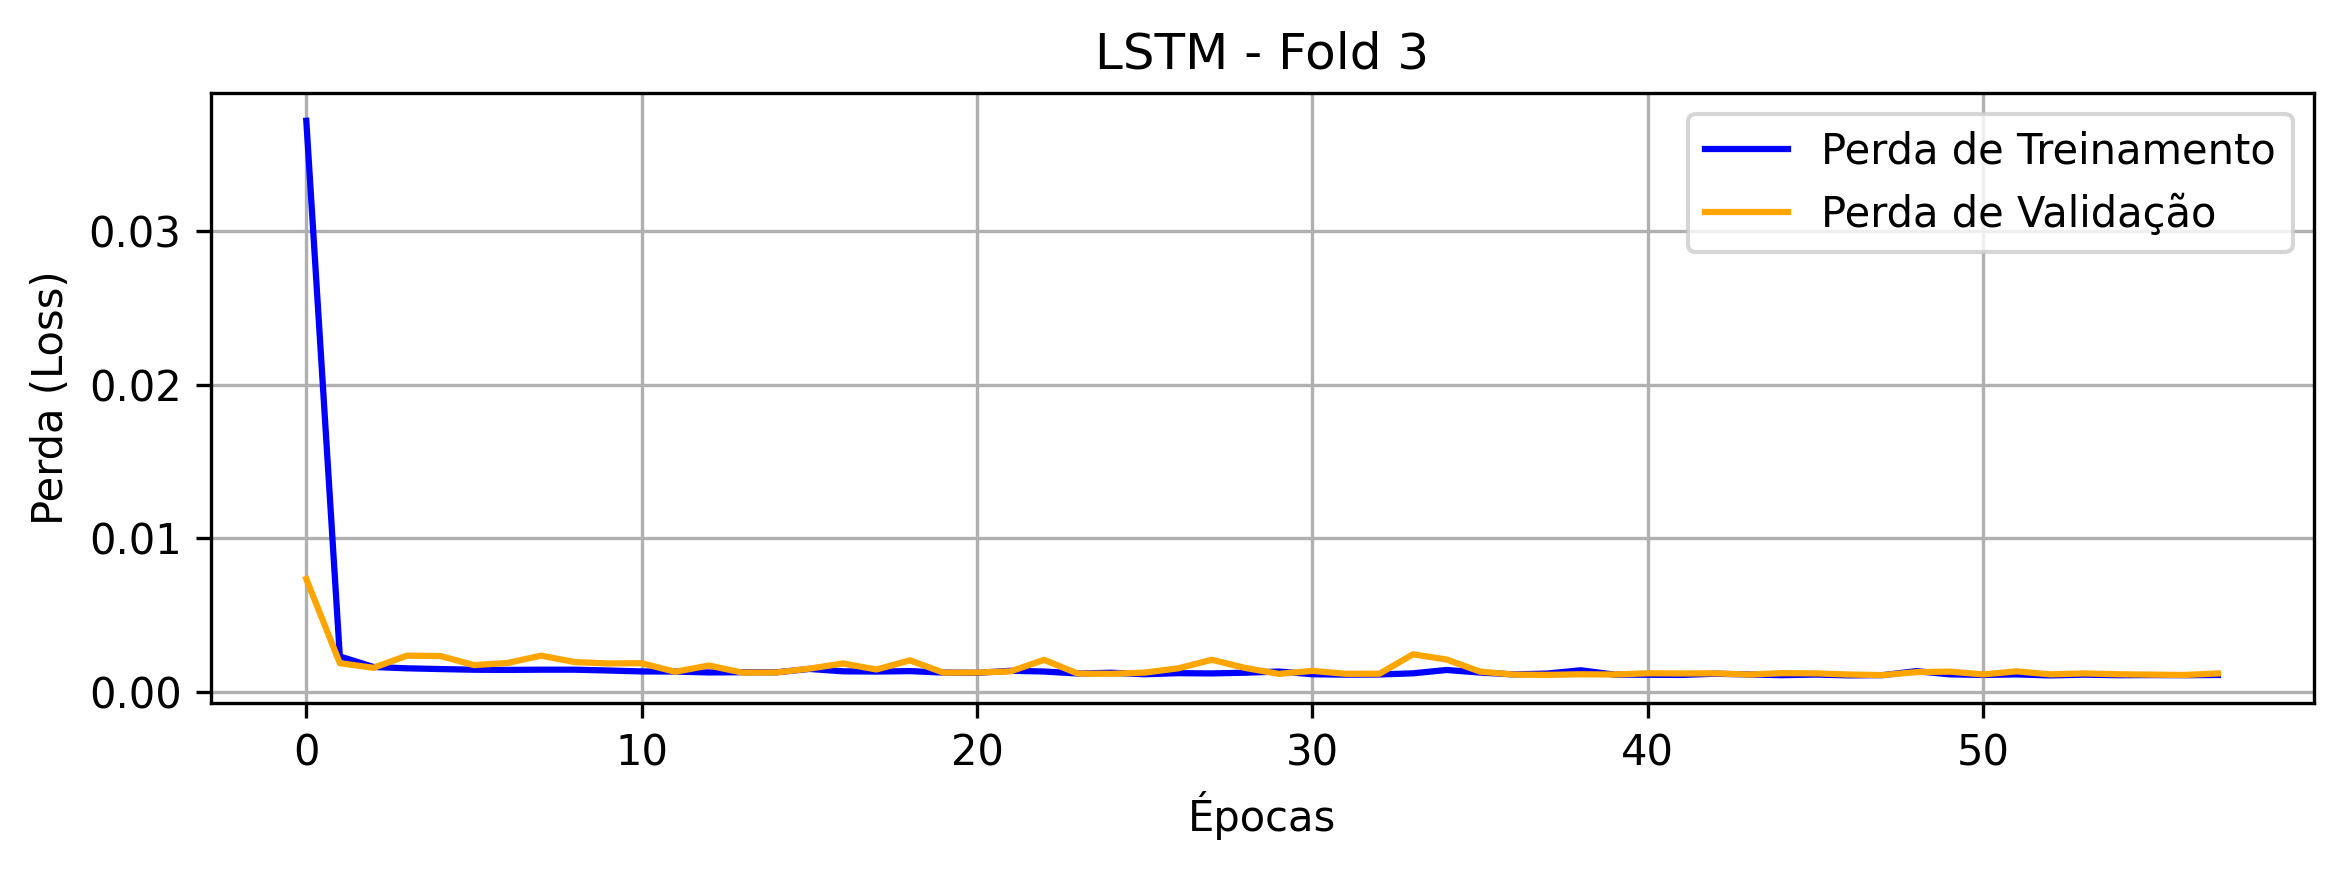

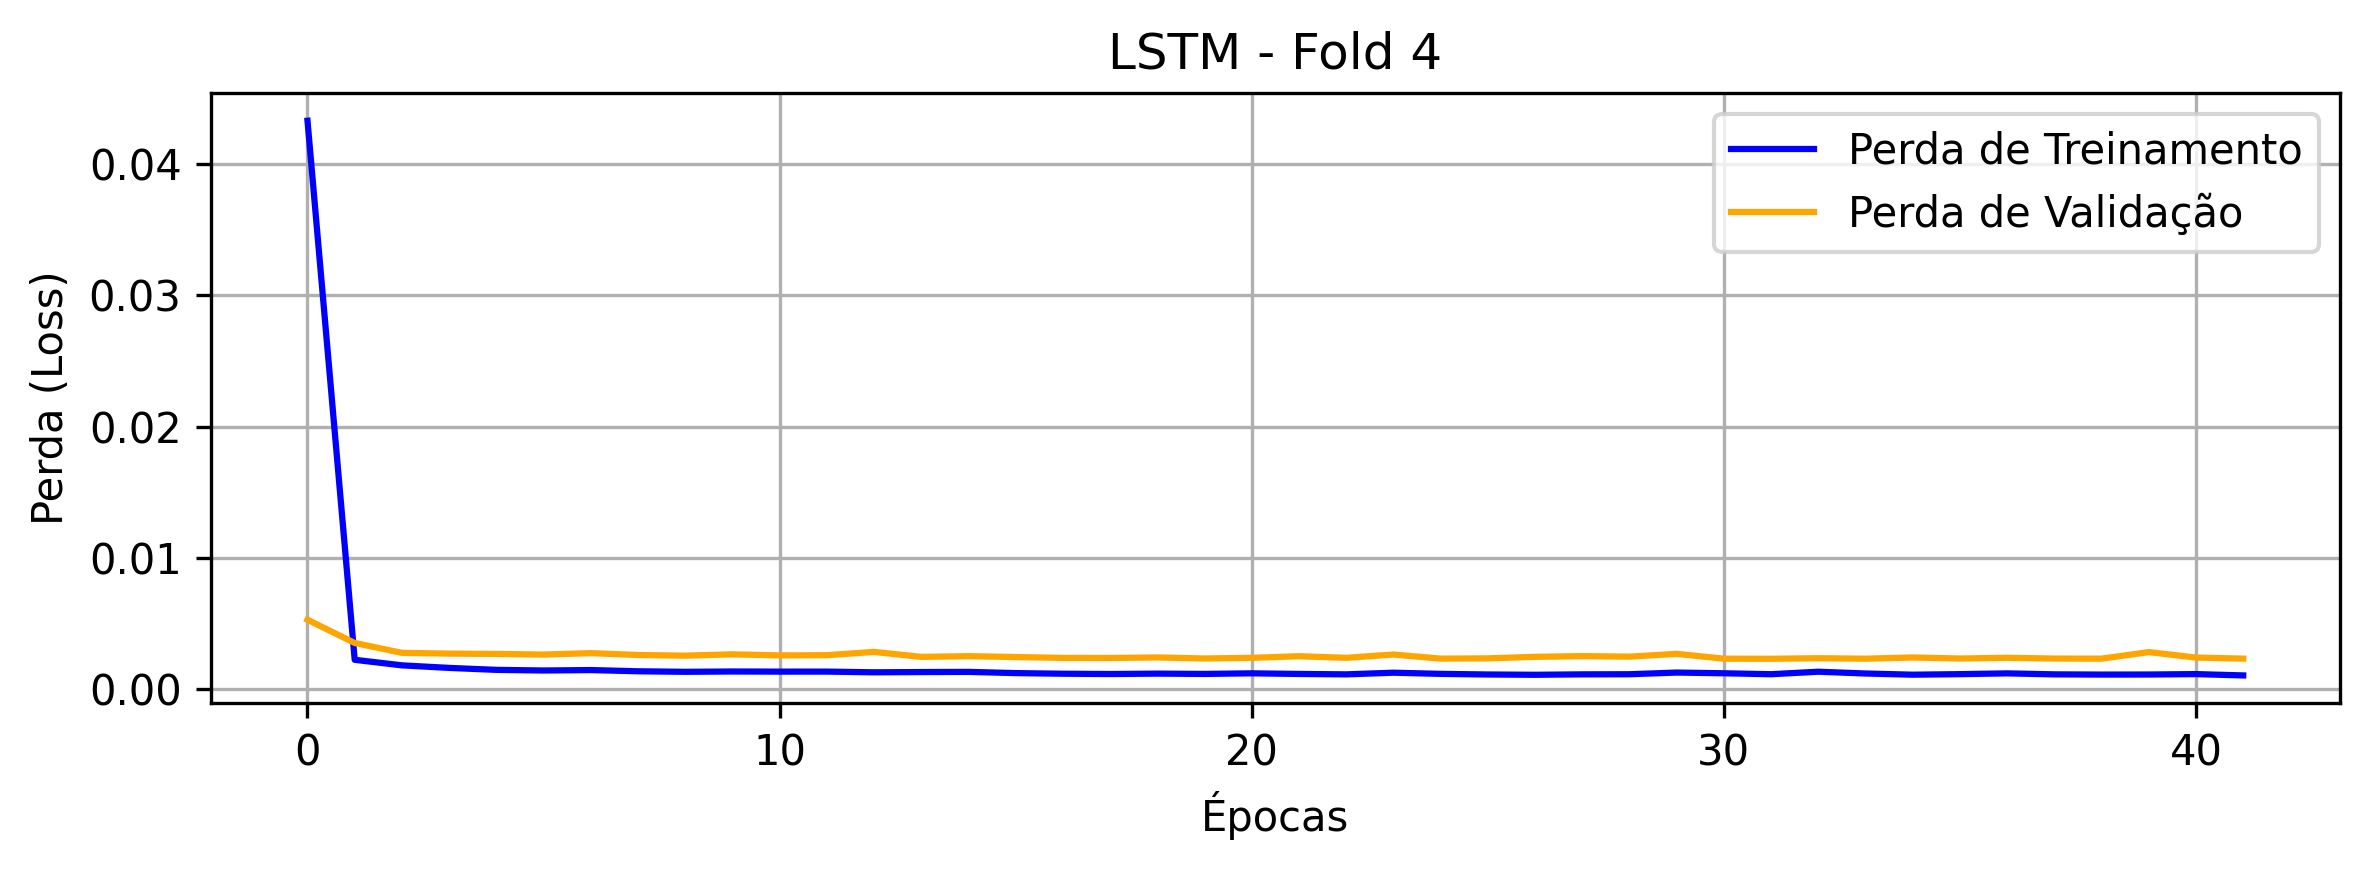

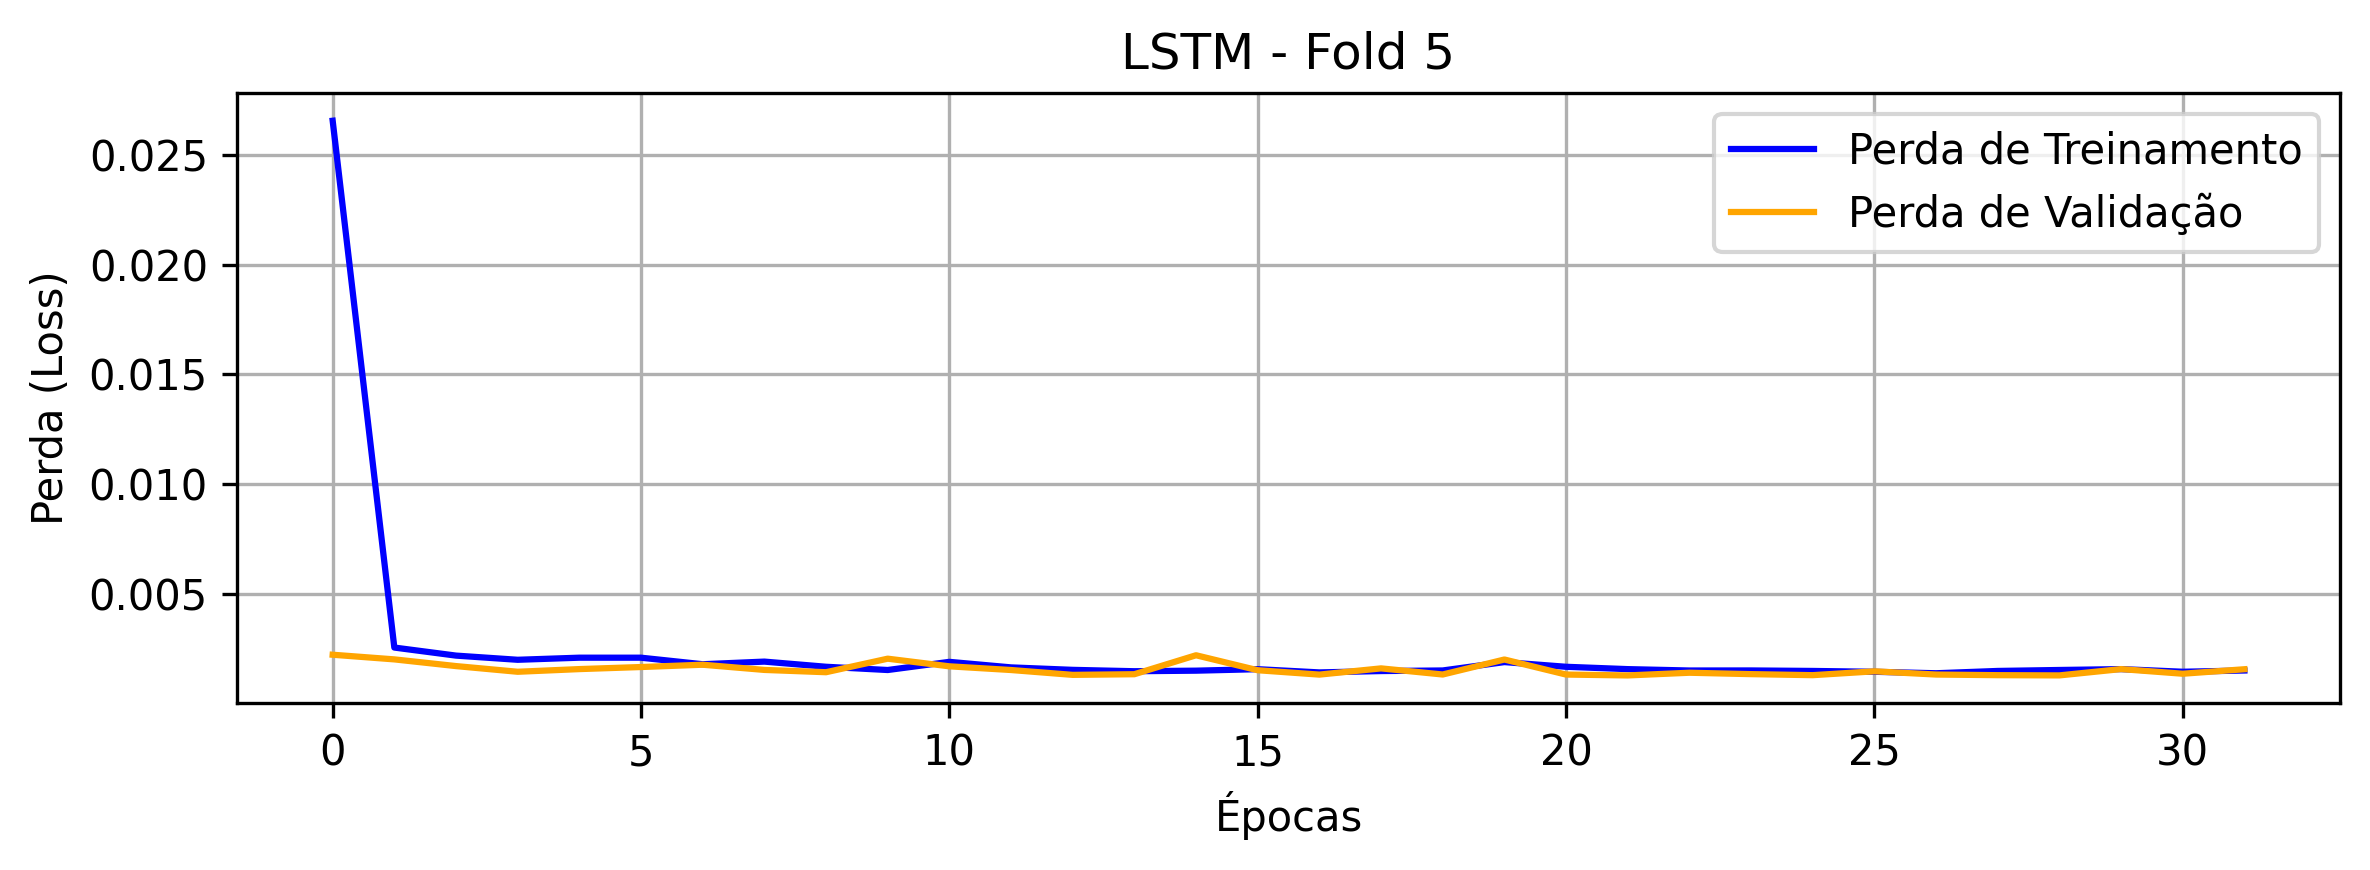

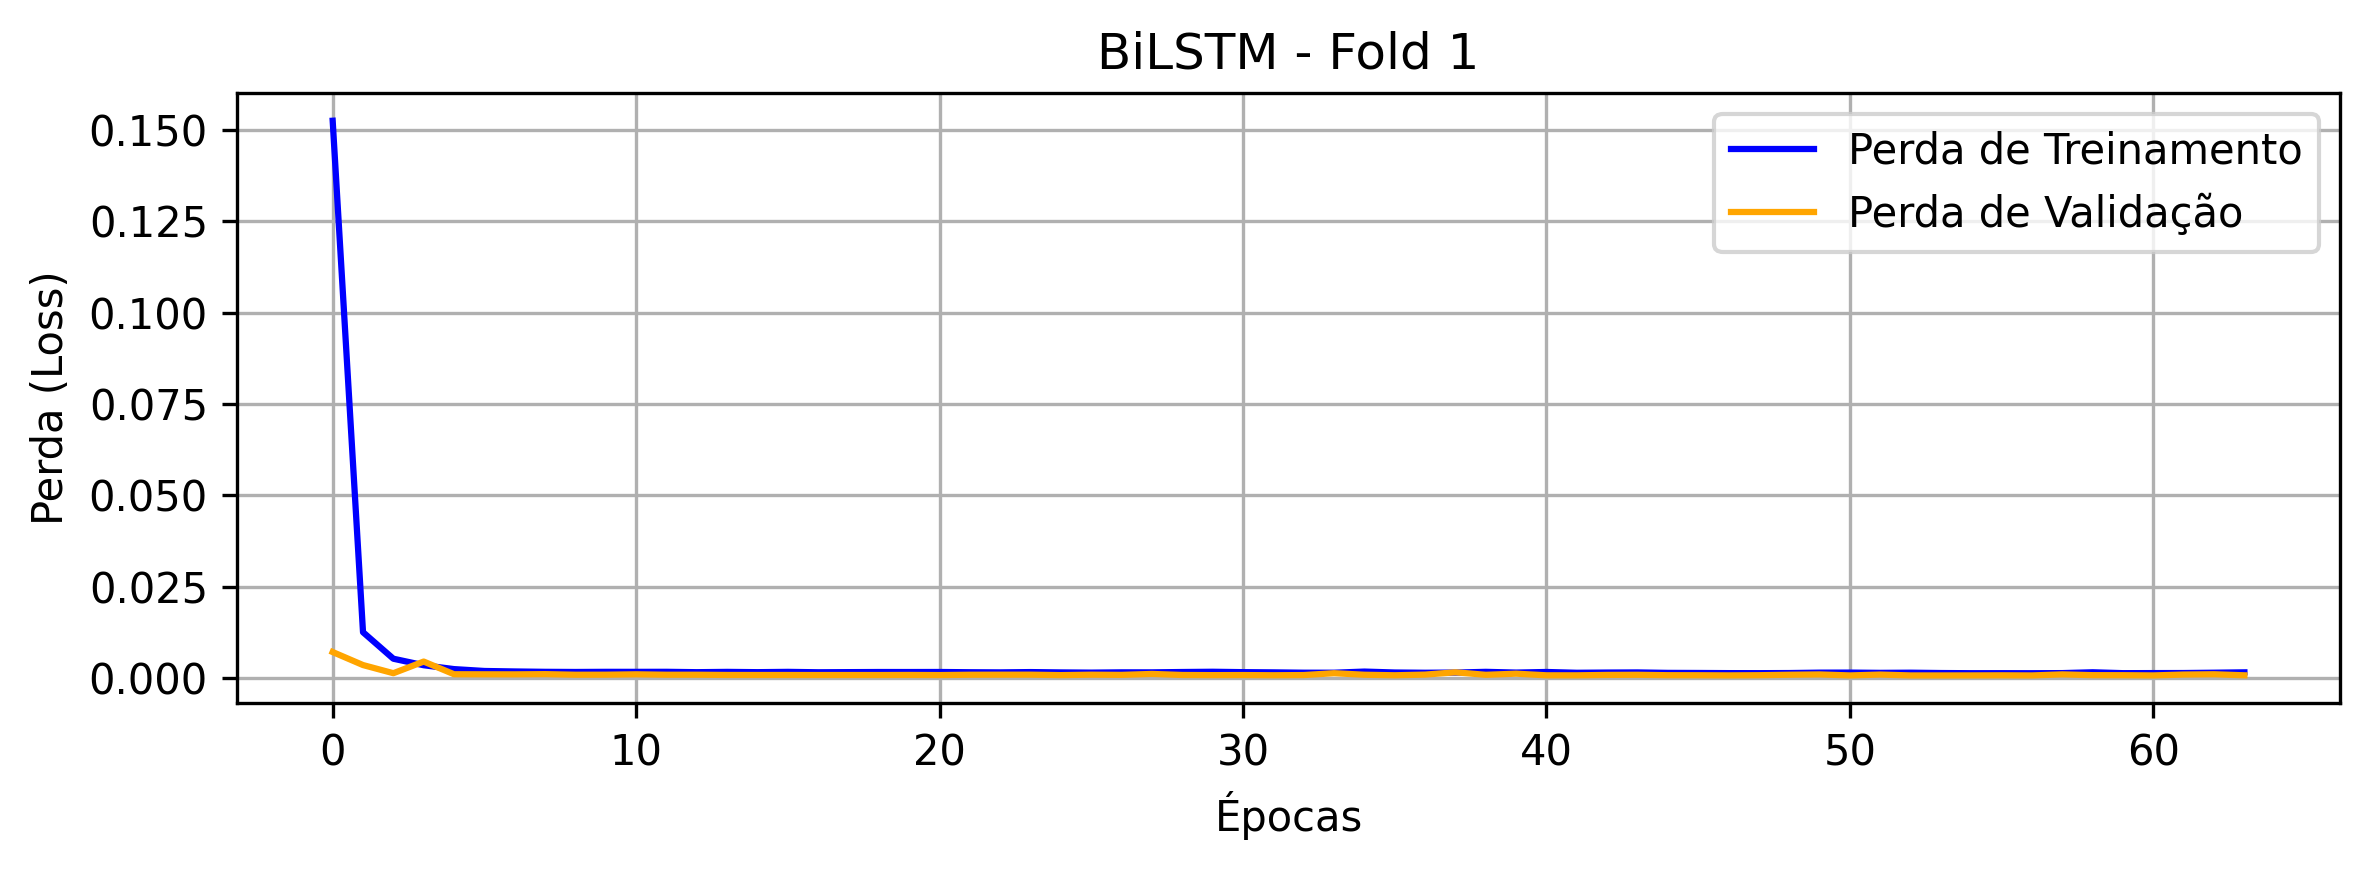

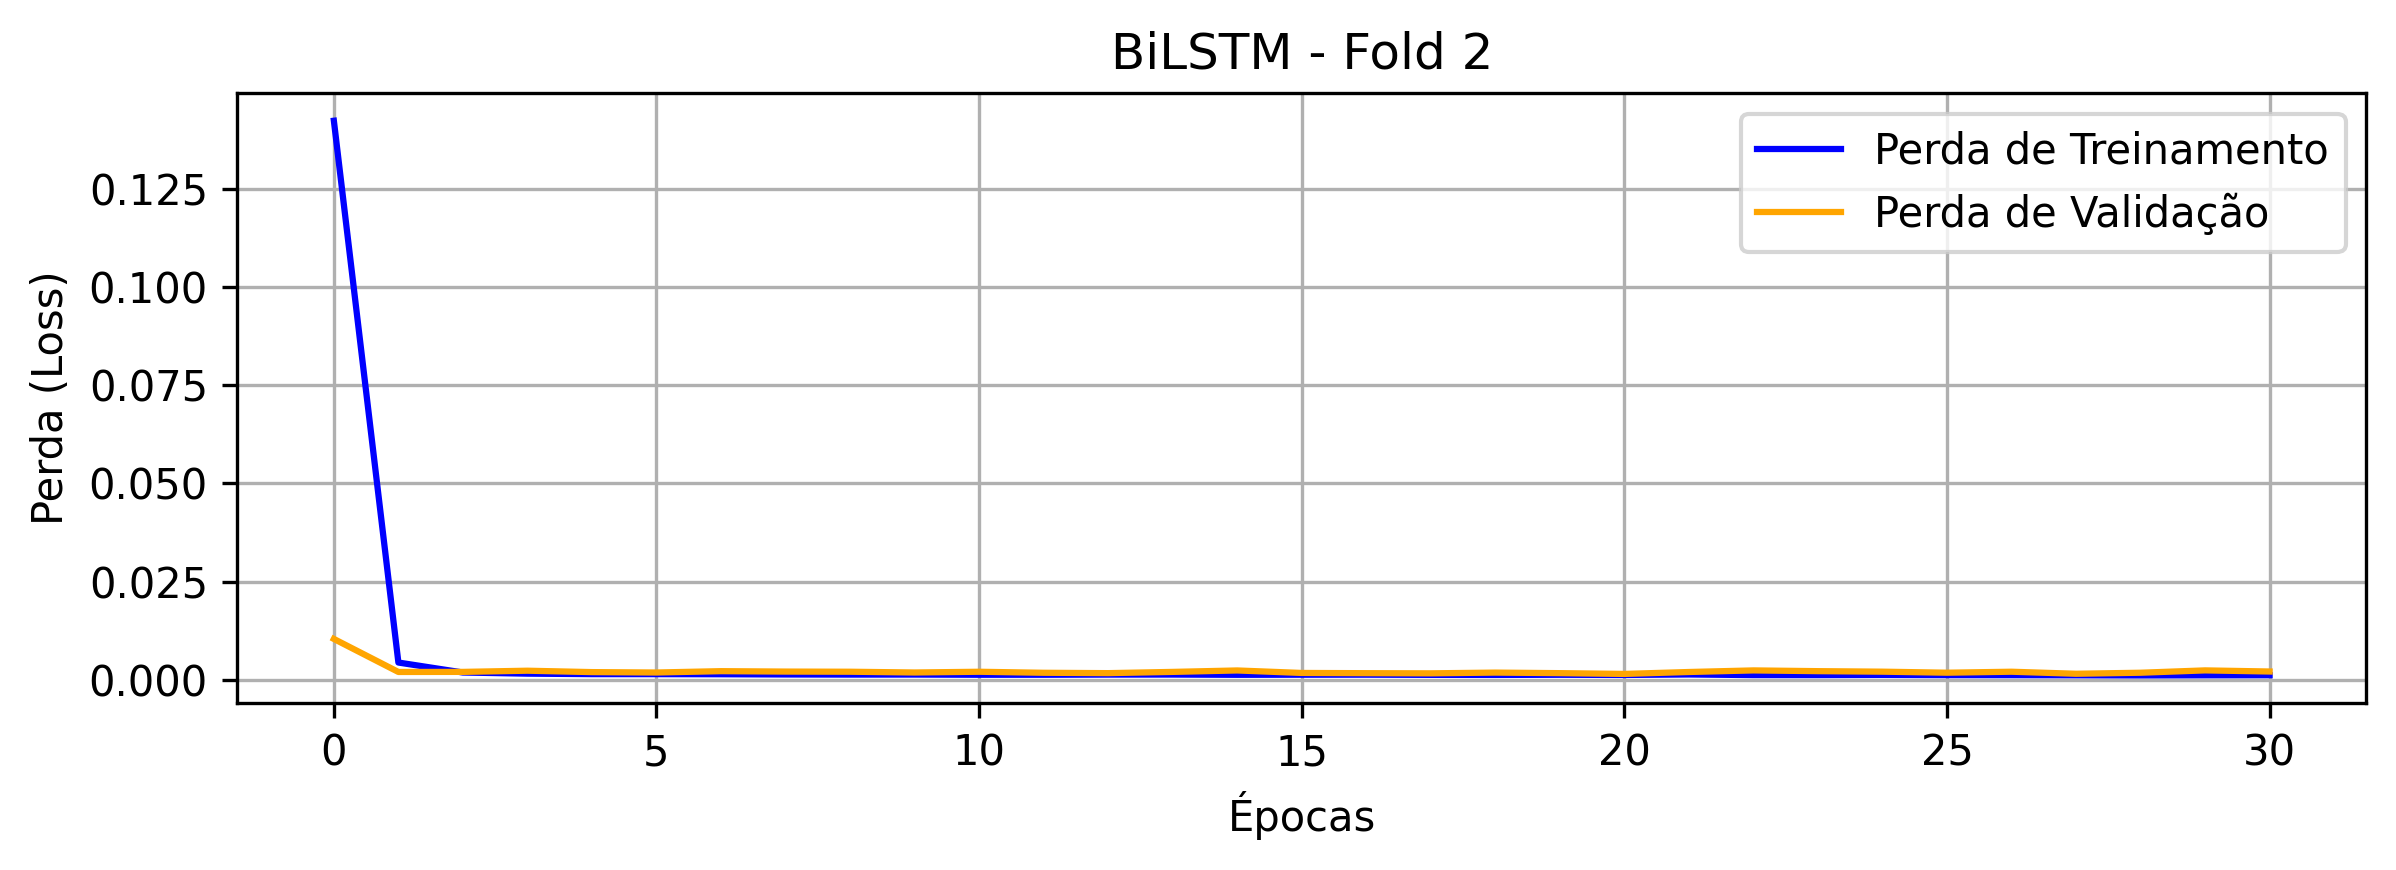

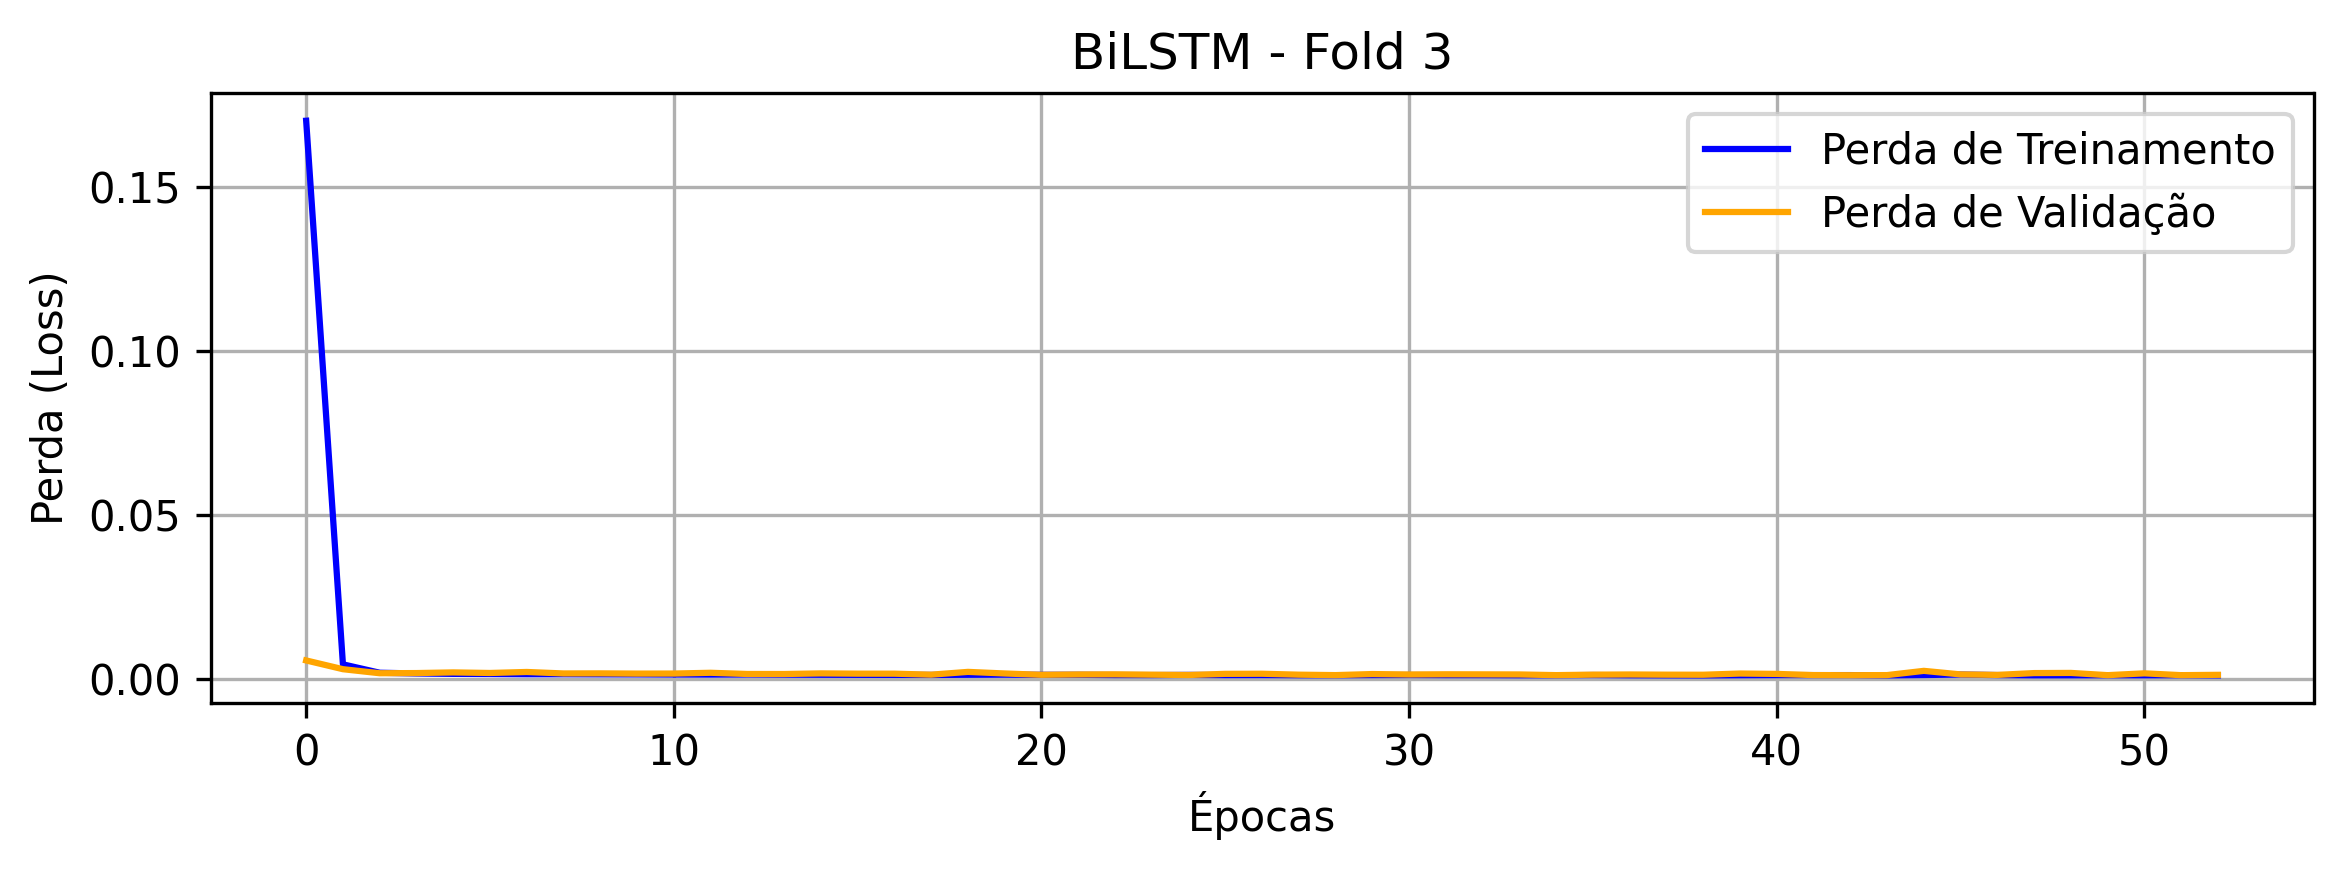

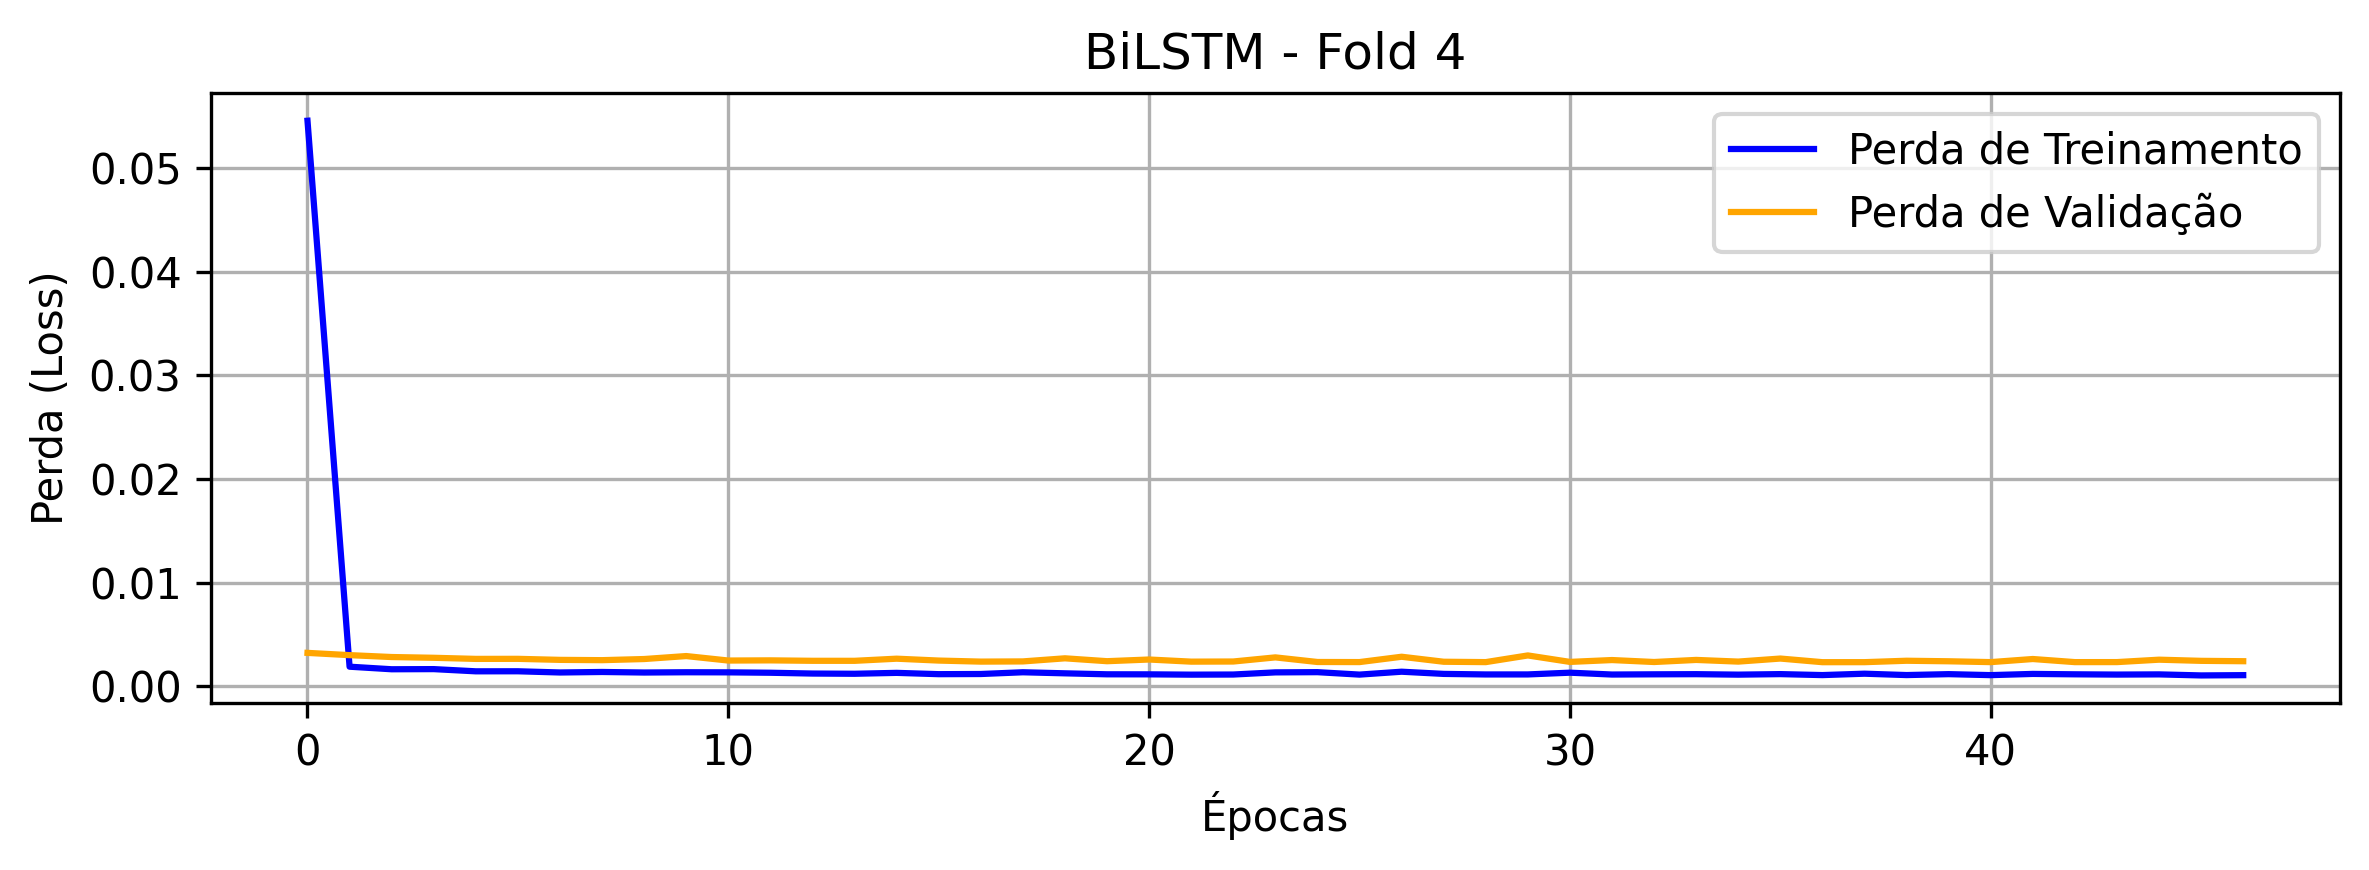

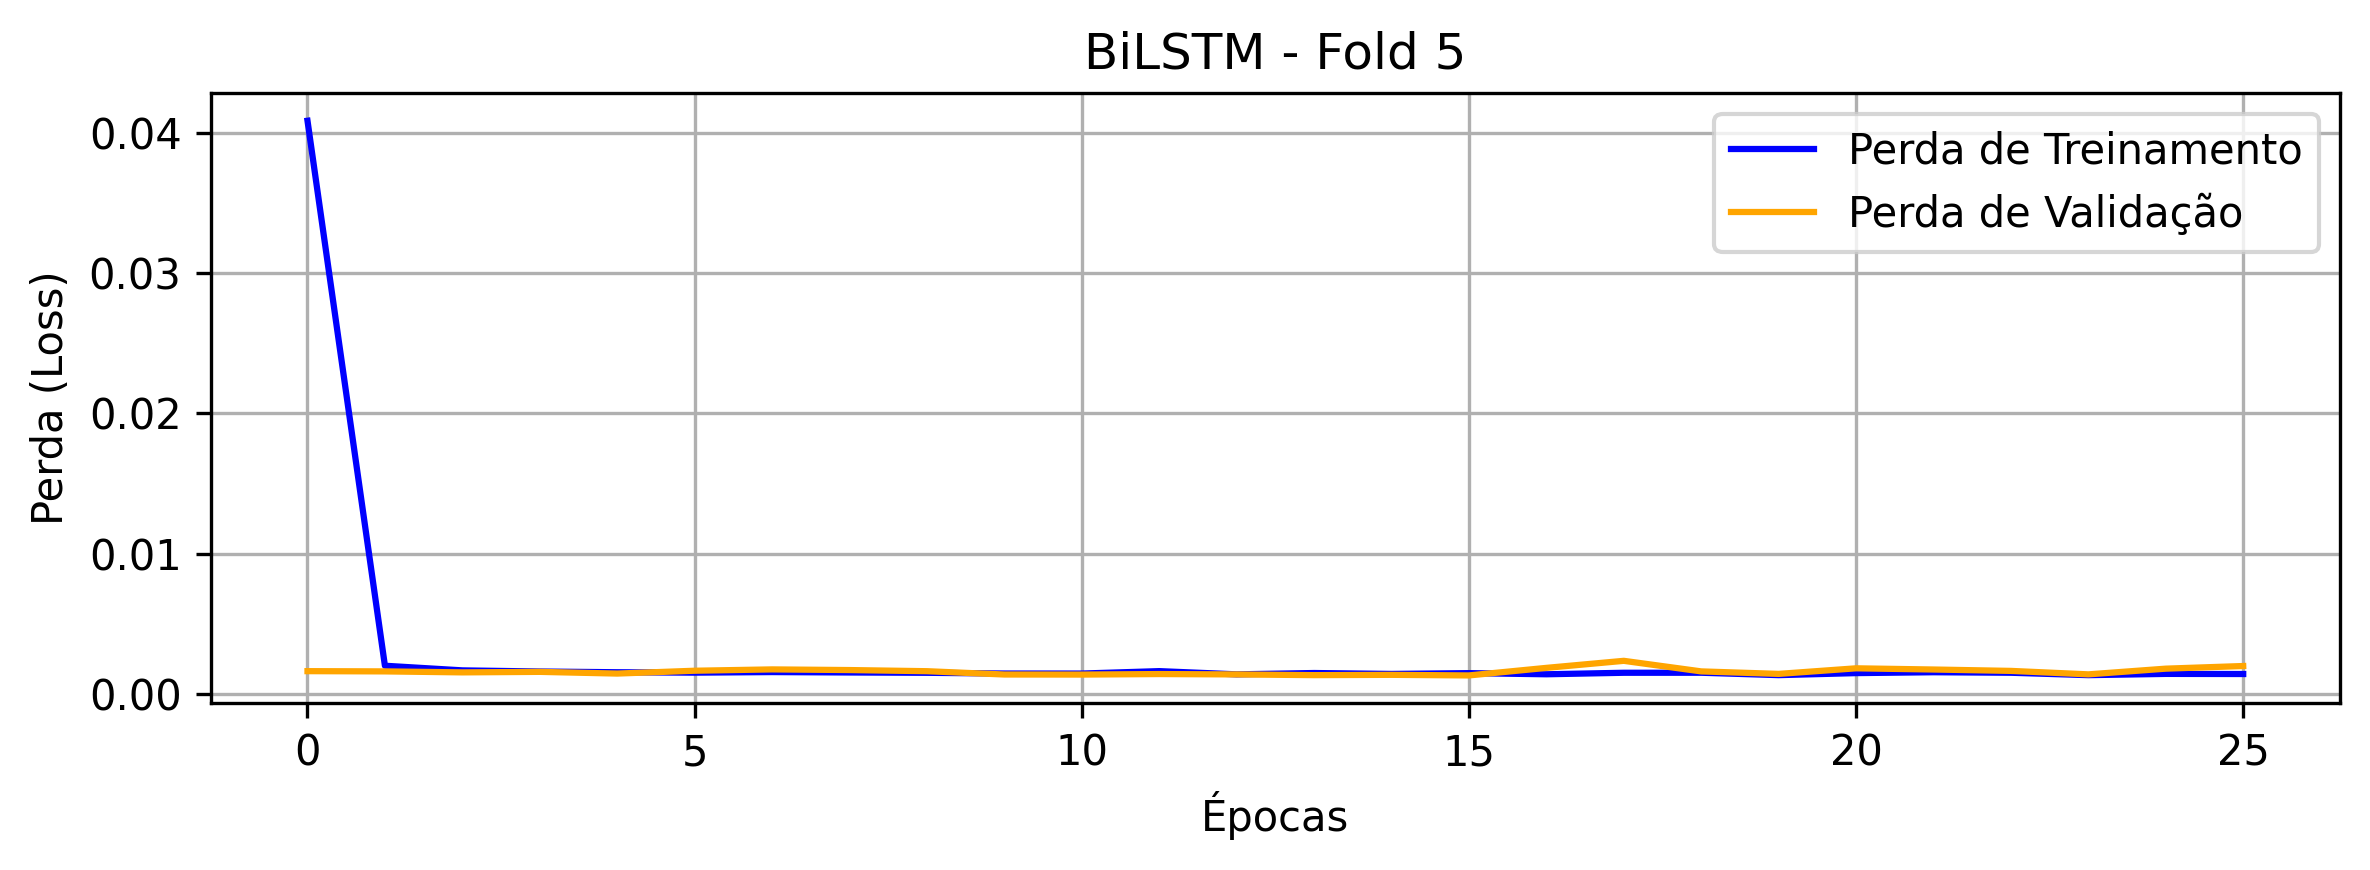

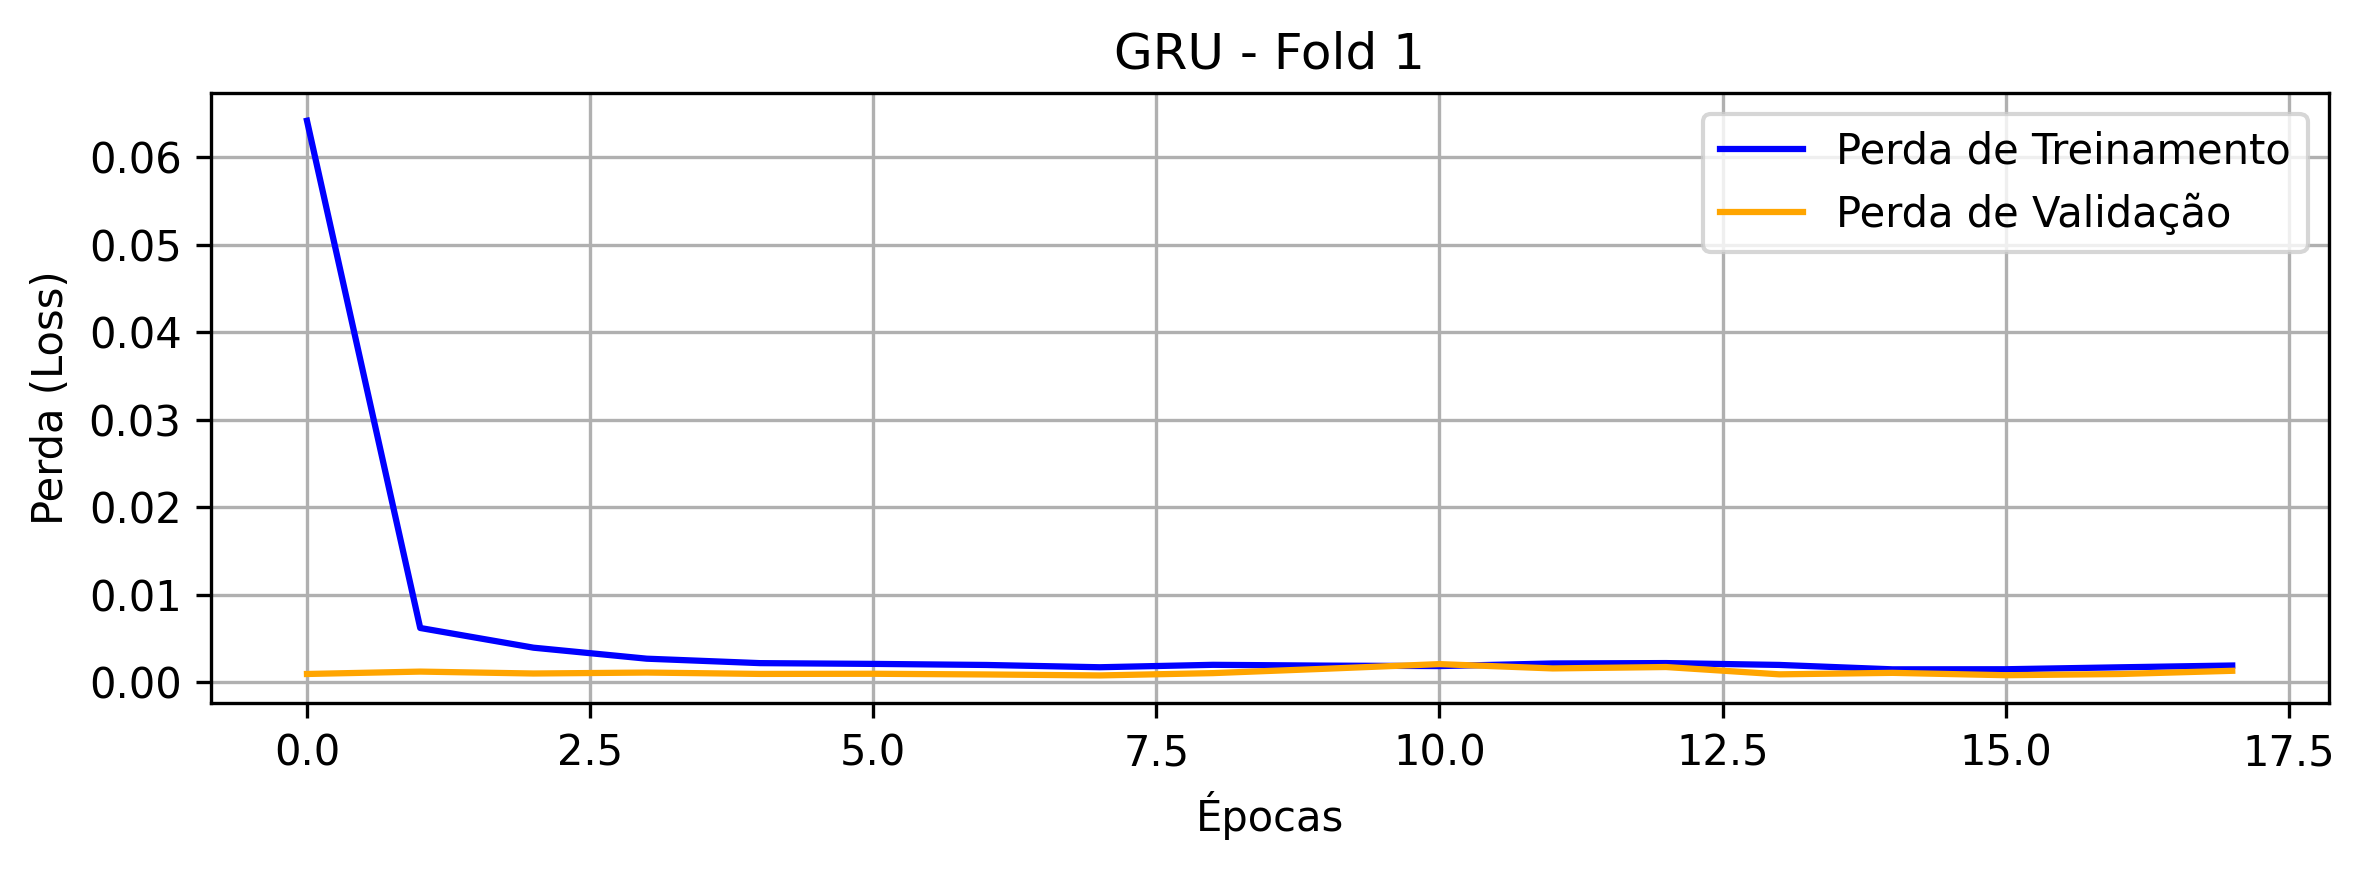

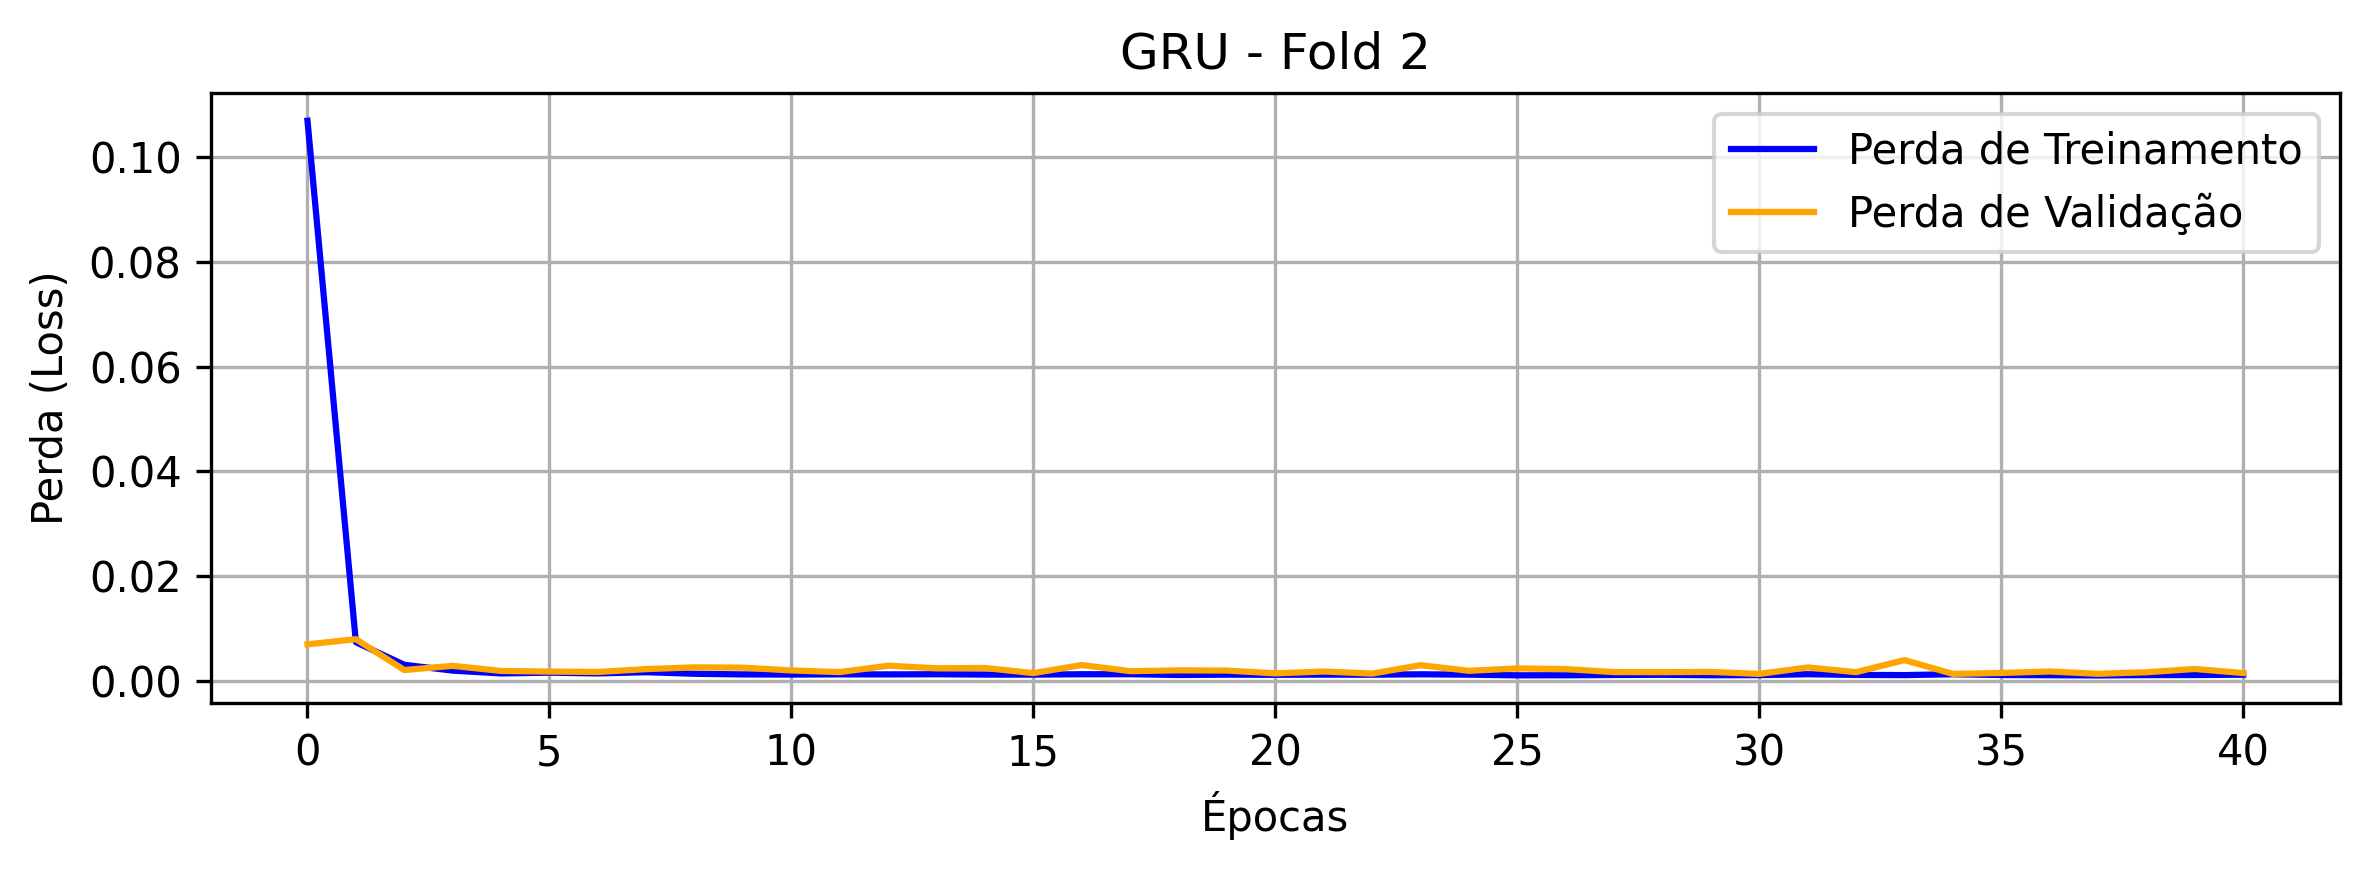

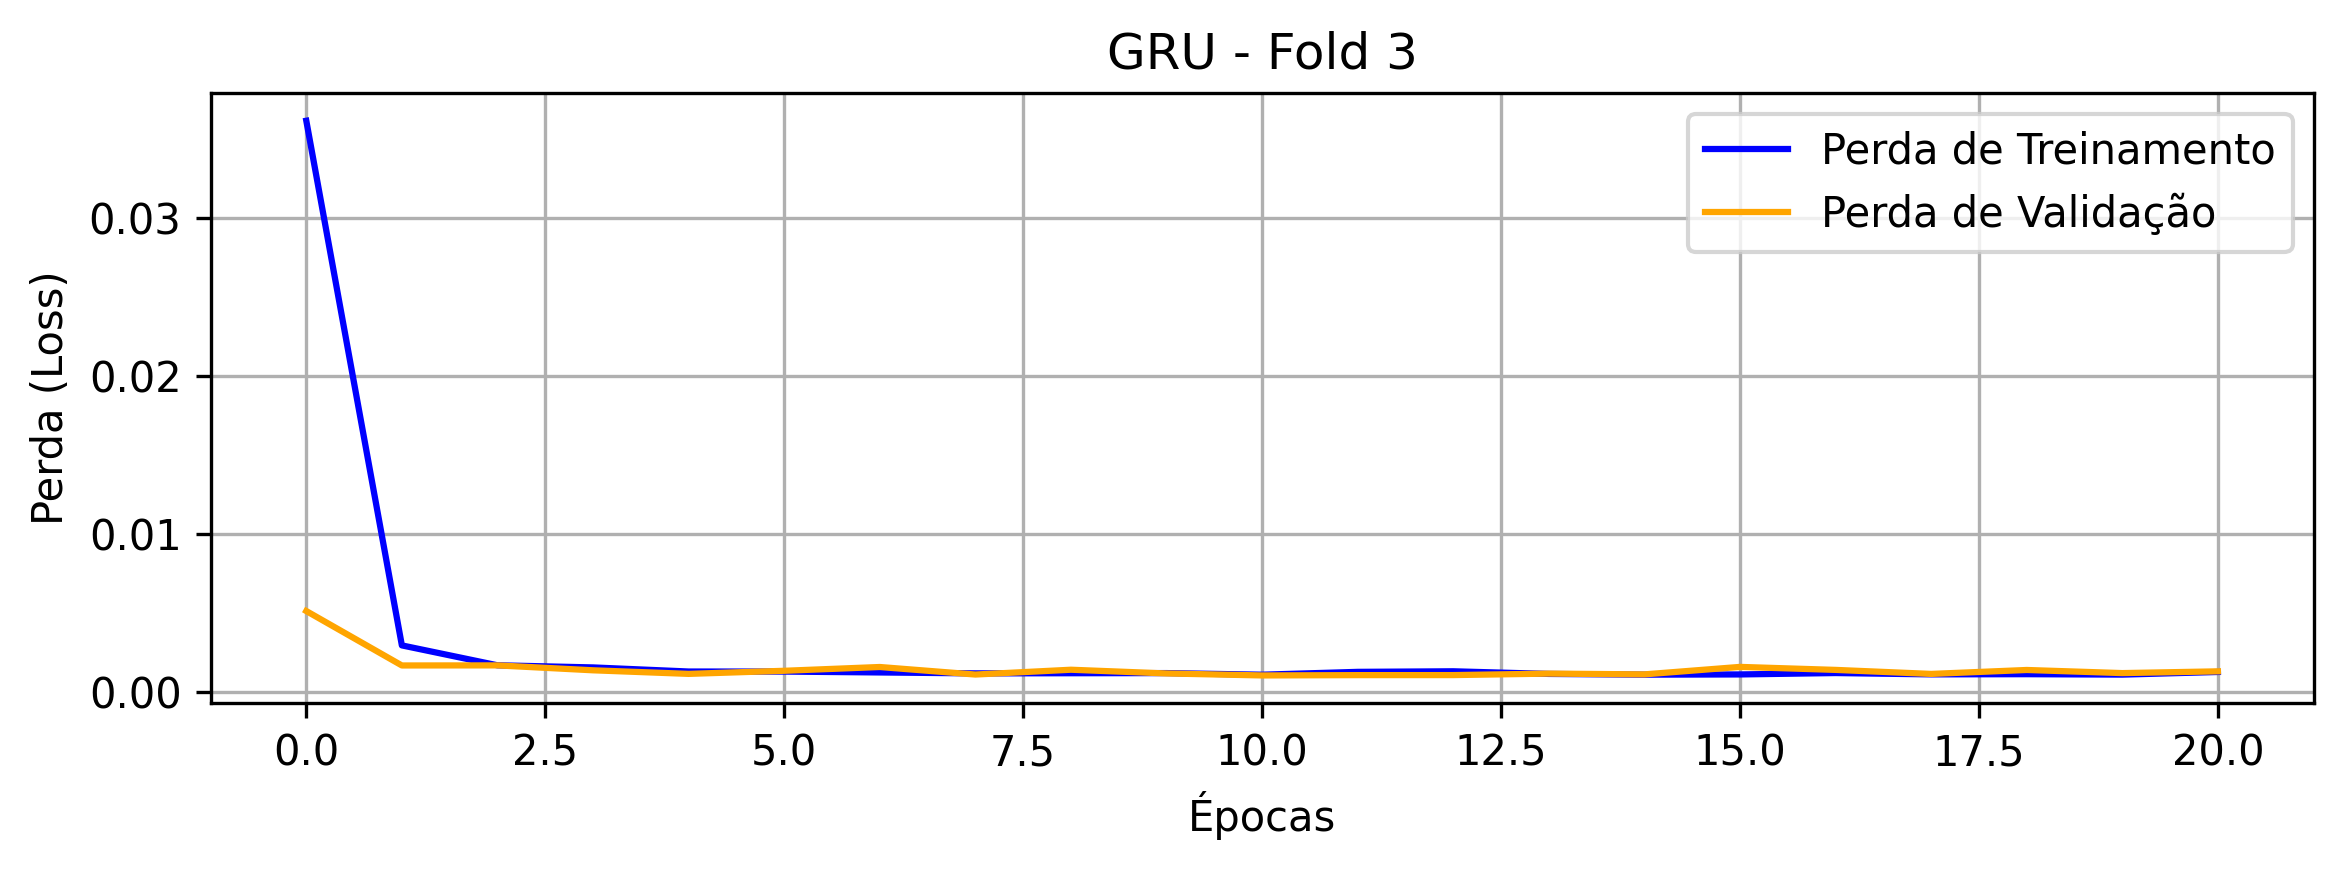

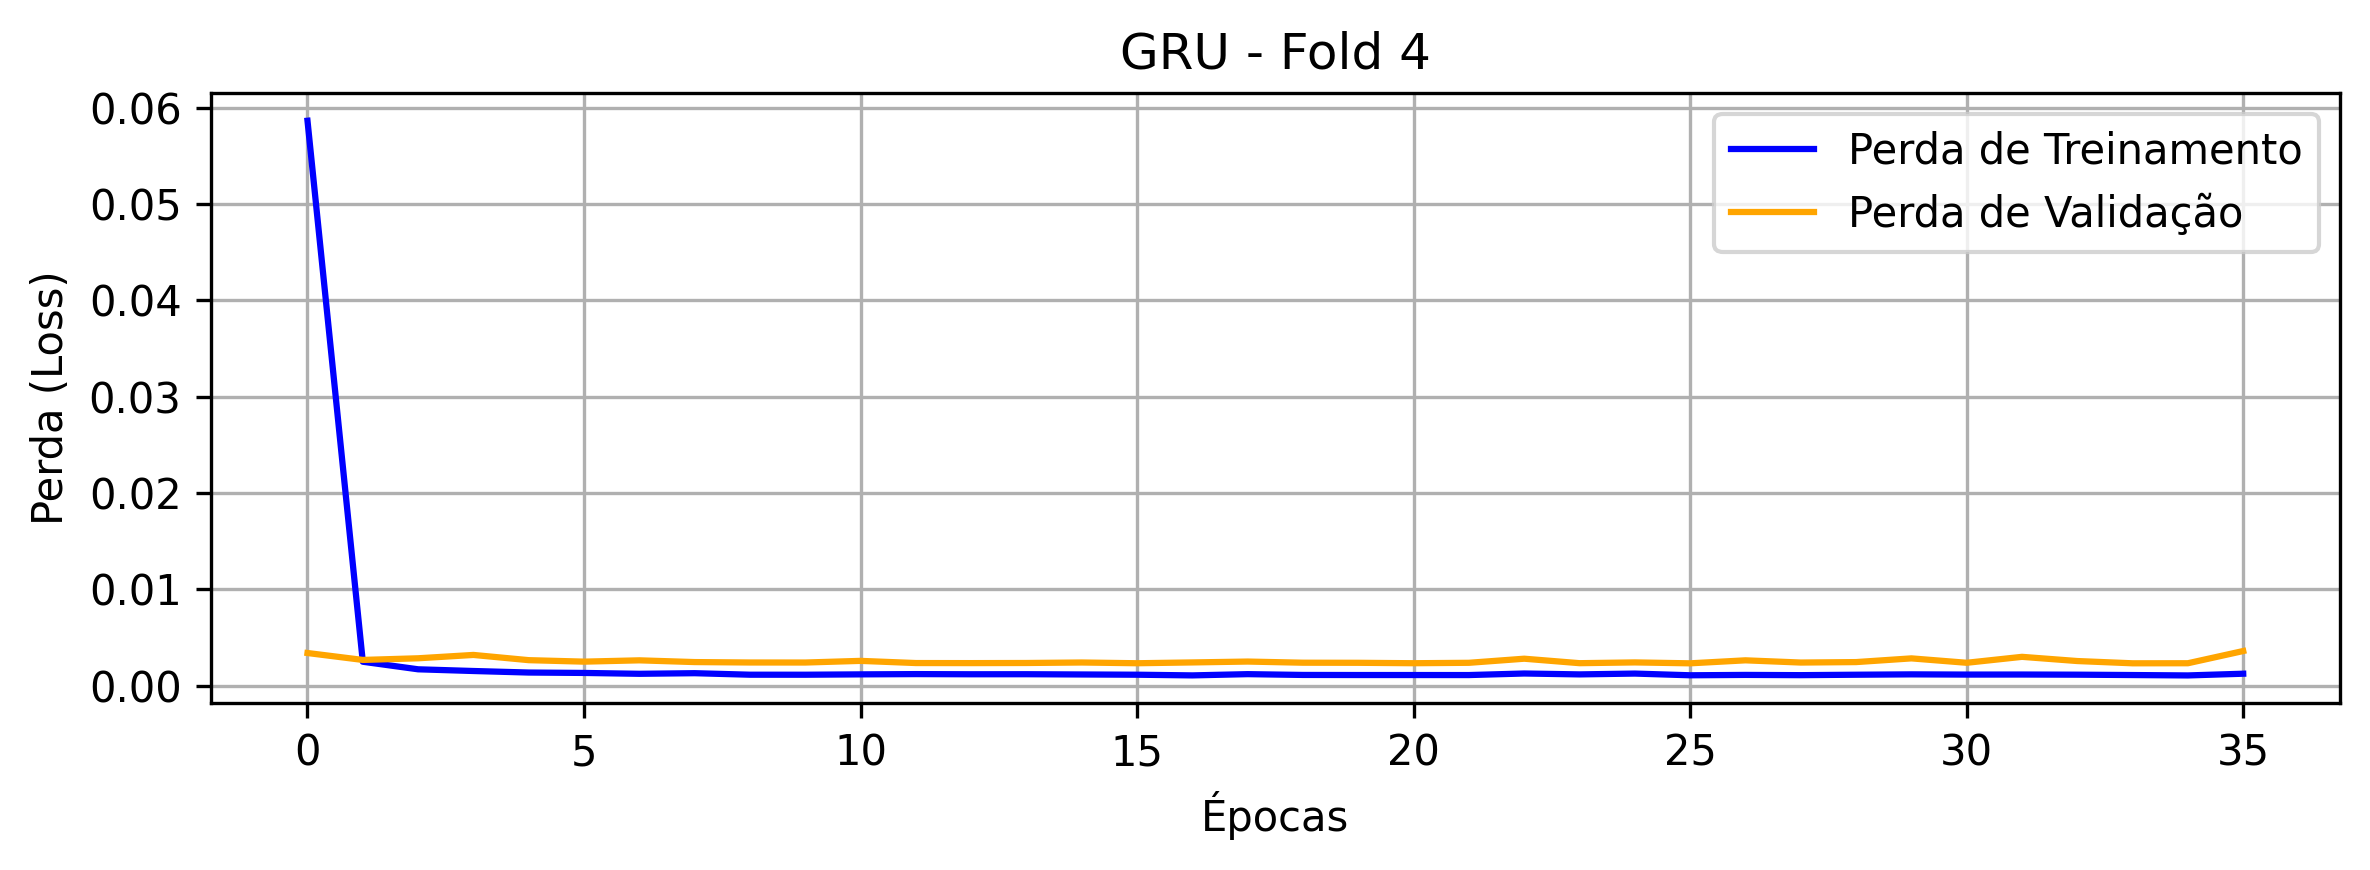

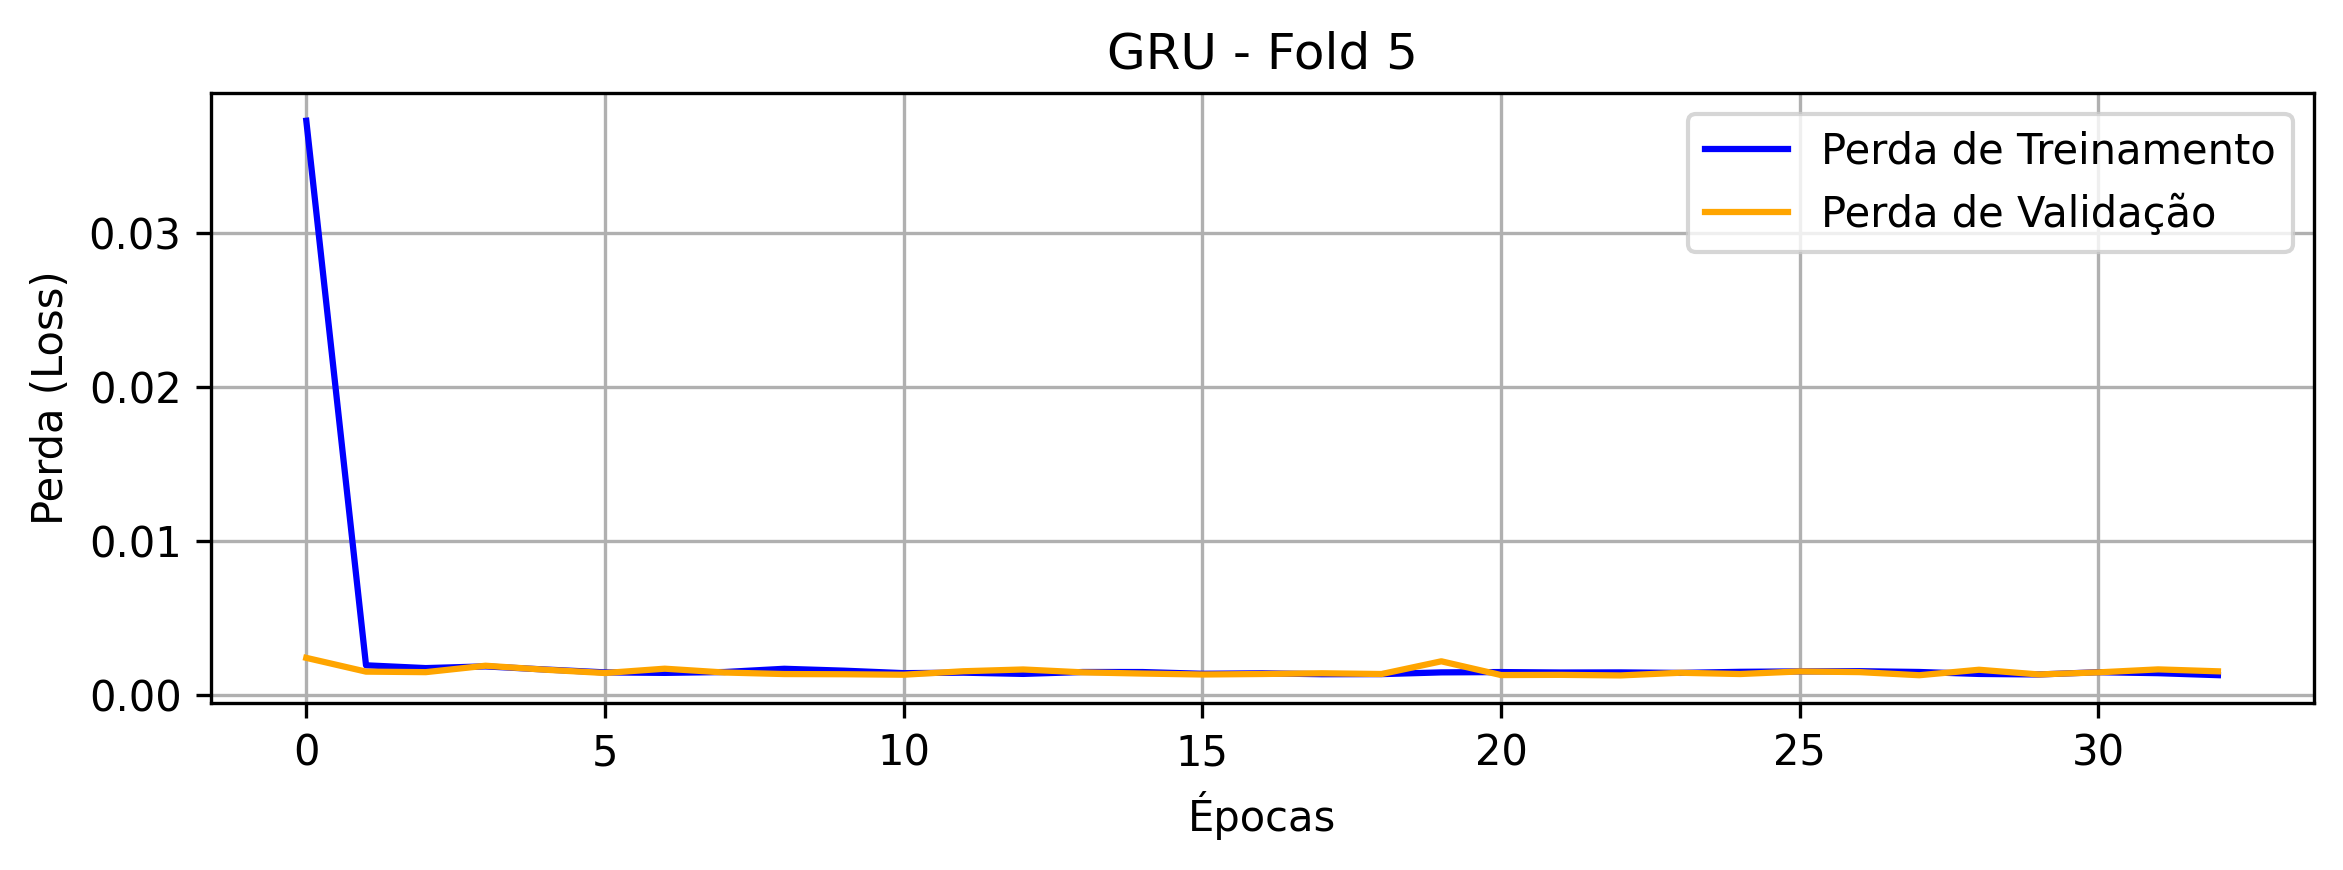

In [54]:
# Curvas de aprendizado
import os
output_dir = "results"
os.makedirs(output_dir, exist_ok=True) 
for model_name, results in detailed_results.items():
    for fold_data in results:
        history = fold_data['history']
        fold = fold_data["fold"]  # Recupera o número do fold
        
        plt.figure(figsize=(8, 3), dpi=300)
        plt.plot(history['loss'], label='Perda de Treinamento', color='blue')
        plt.plot(history['val_loss'], label='Perda de Validação', color='orange')
        plt.title(f'{model_name} - Fold {fold}')
        plt.xlabel('Épocas')
        plt.ylabel('Perda (Loss)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

#         filename = os.path.join(output_dir, f"{model_name}_Fold_{fold}.png")
#         plt.savefig(filename)
#         plt.close() 
#         print(f"Gráfico salvo: {filename}")

In [34]:
# Média das métricas
for model_name, results in detailed_results.items():
    mse_vals = [fold_data['MSE'] for fold_data in results]
    rmse_vals = [fold_data['RMSE'] for fold_data in results]
    mae_vals = [fold_data['MAE'] for fold_data in results]
    r2_vals = [fold_data['R2'] for fold_data in results]
    print(f"\nModelo: {model_name}")
    print(f"MSE Médio: {np.mean(mse_vals):.4f} ± {np.std(mse_vals):.4f}")
    print(f"RMSE Médio: {np.mean(rmse_vals):.4f} ± {np.std(rmse_vals):.4f}")
    print(f"MAE Médio: {np.mean(mae_vals):.4f} ± {np.std(mae_vals):.4f}")
    print(f"R² Médio: {np.mean(r2_vals):.4f} ± {np.std(r2_vals):.4f}")


Modelo: LSTM
MSE Médio: 0.0016 ± 0.0003
RMSE Médio: 0.0399 ± 0.0037
MAE Médio: 0.0299 ± 0.0014
R² Médio: 0.3426 ± 0.0720

Modelo: BiLSTM
MSE Médio: 0.0017 ± 0.0004
RMSE Médio: 0.0405 ± 0.0045
MAE Médio: 0.0304 ± 0.0030
R² Médio: 0.3190 ± 0.1078

Modelo: GRU
MSE Médio: 0.0016 ± 0.0004
RMSE Médio: 0.0402 ± 0.0048
MAE Médio: 0.0304 ± 0.0038
R² Médio: 0.3335 ± 0.0835


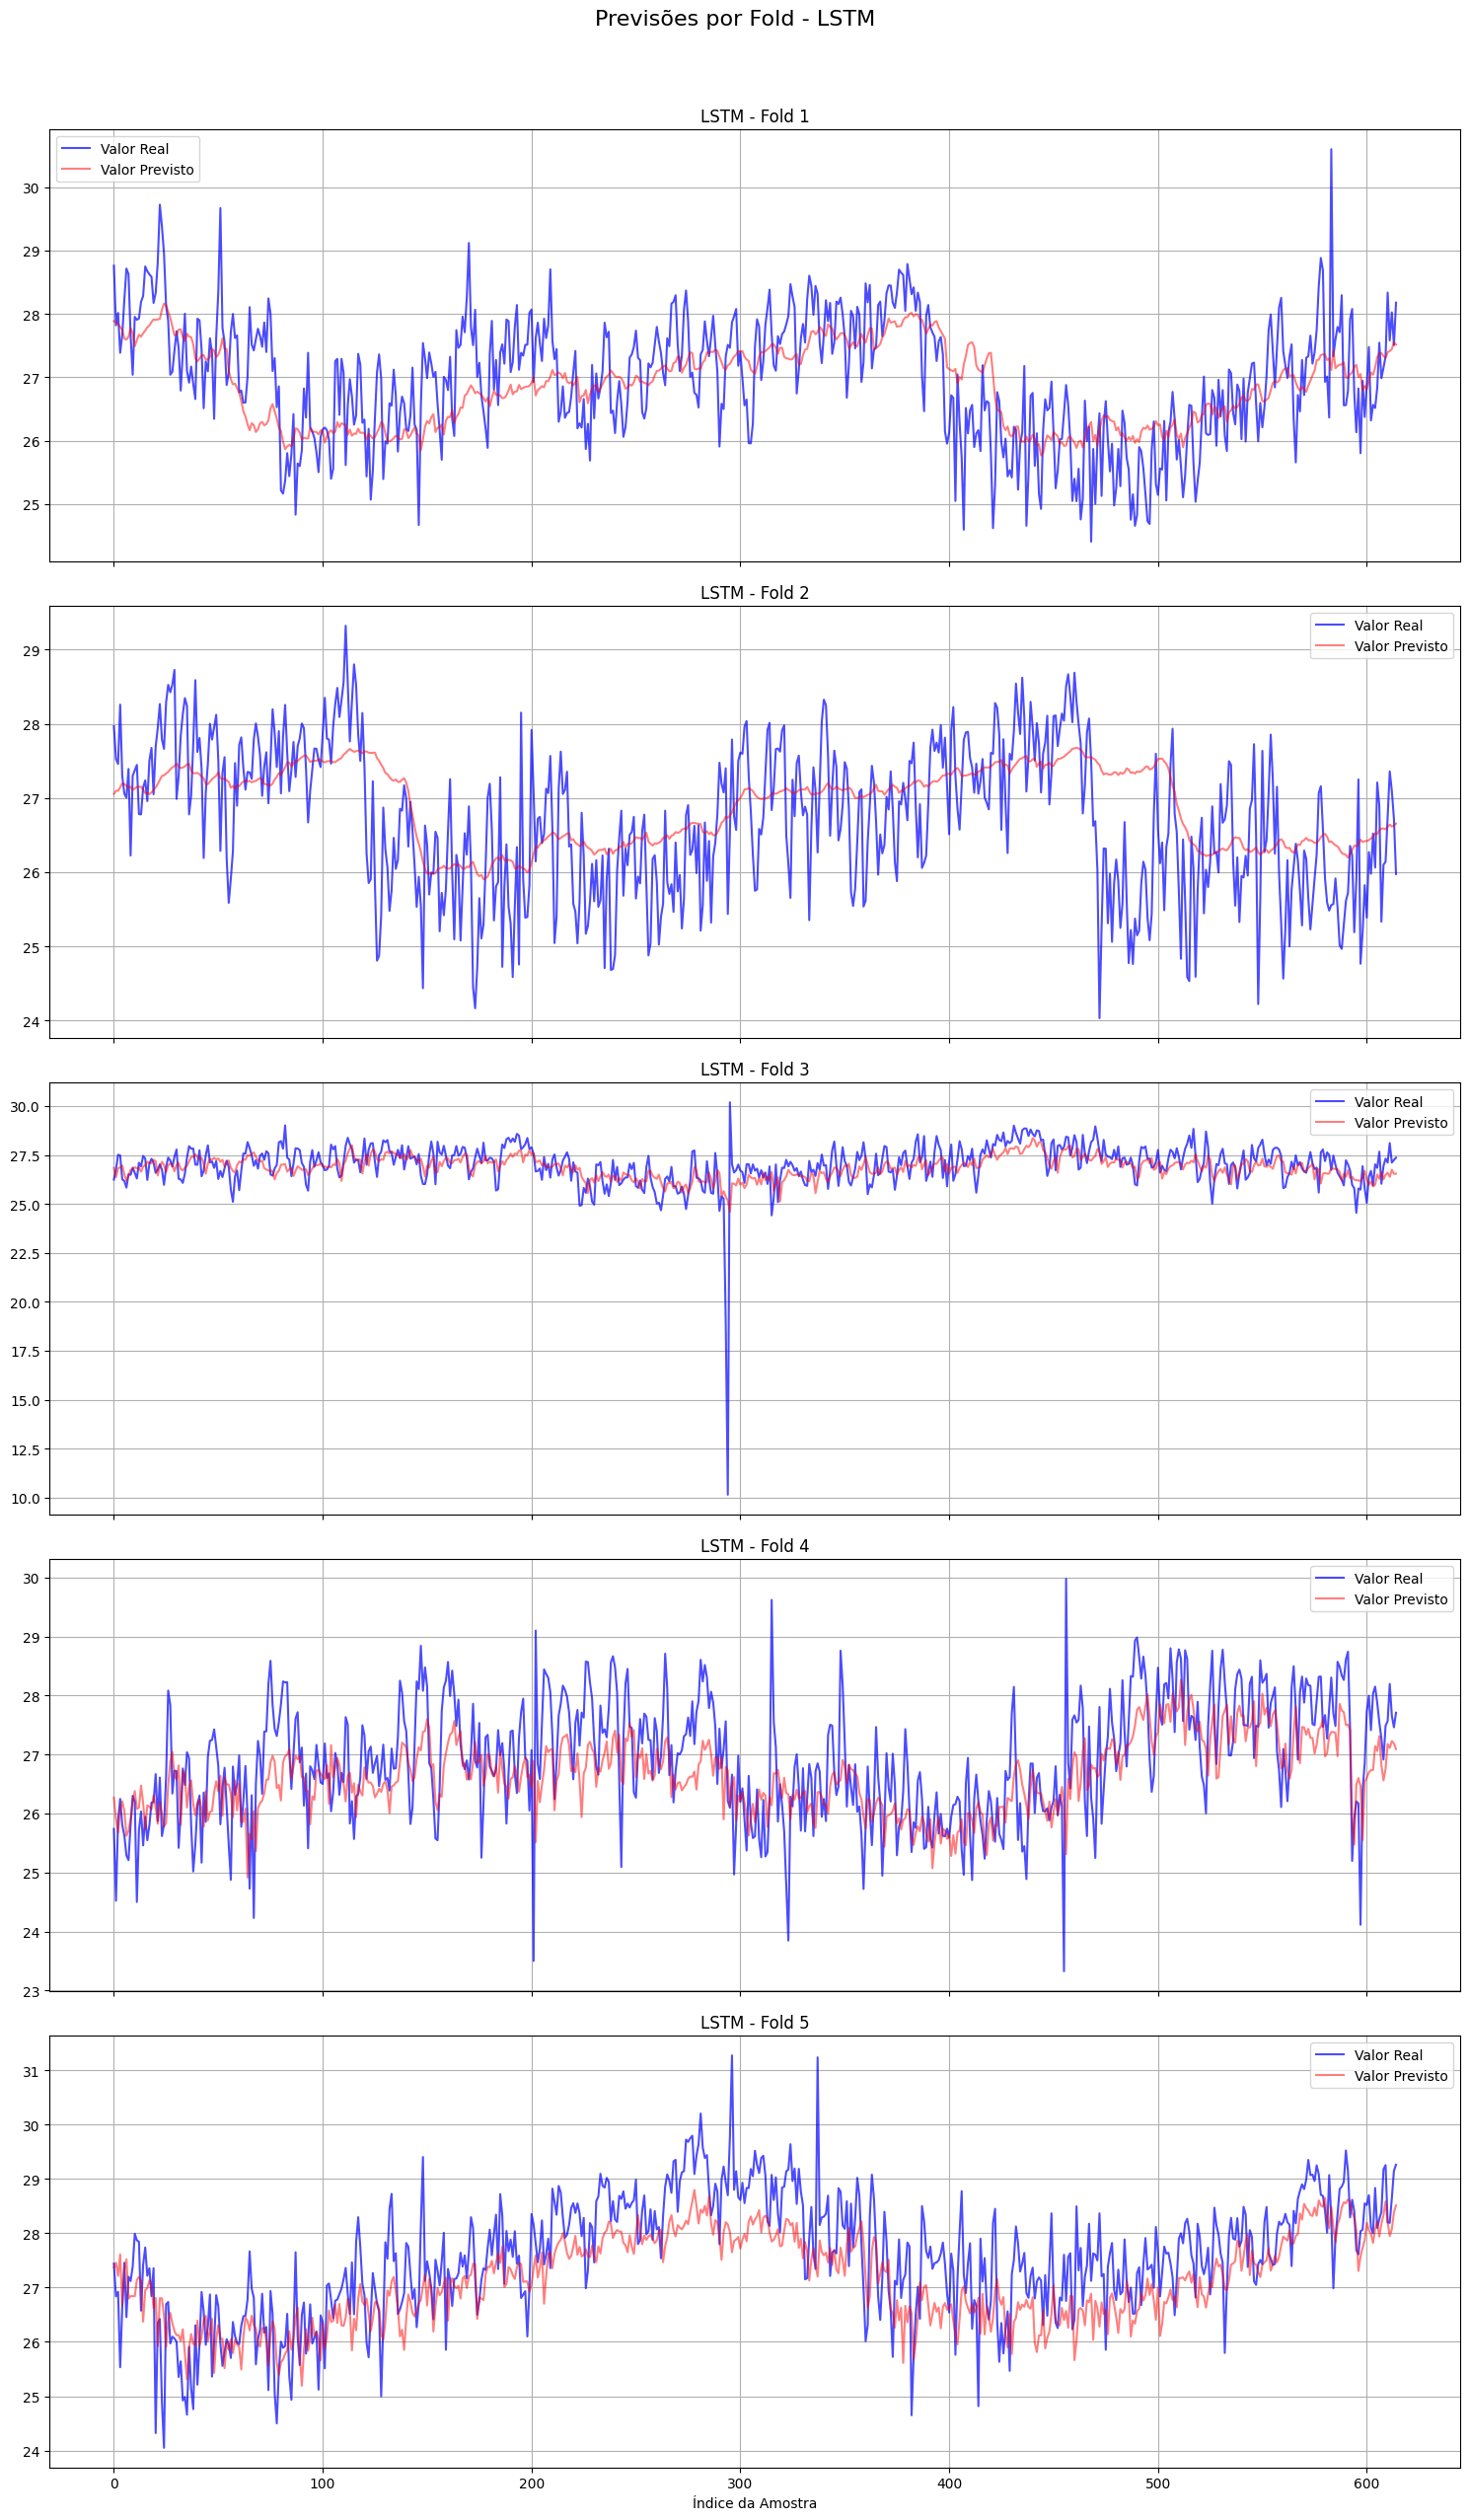

Gráfico salvo: results\LSTM_predictions.png


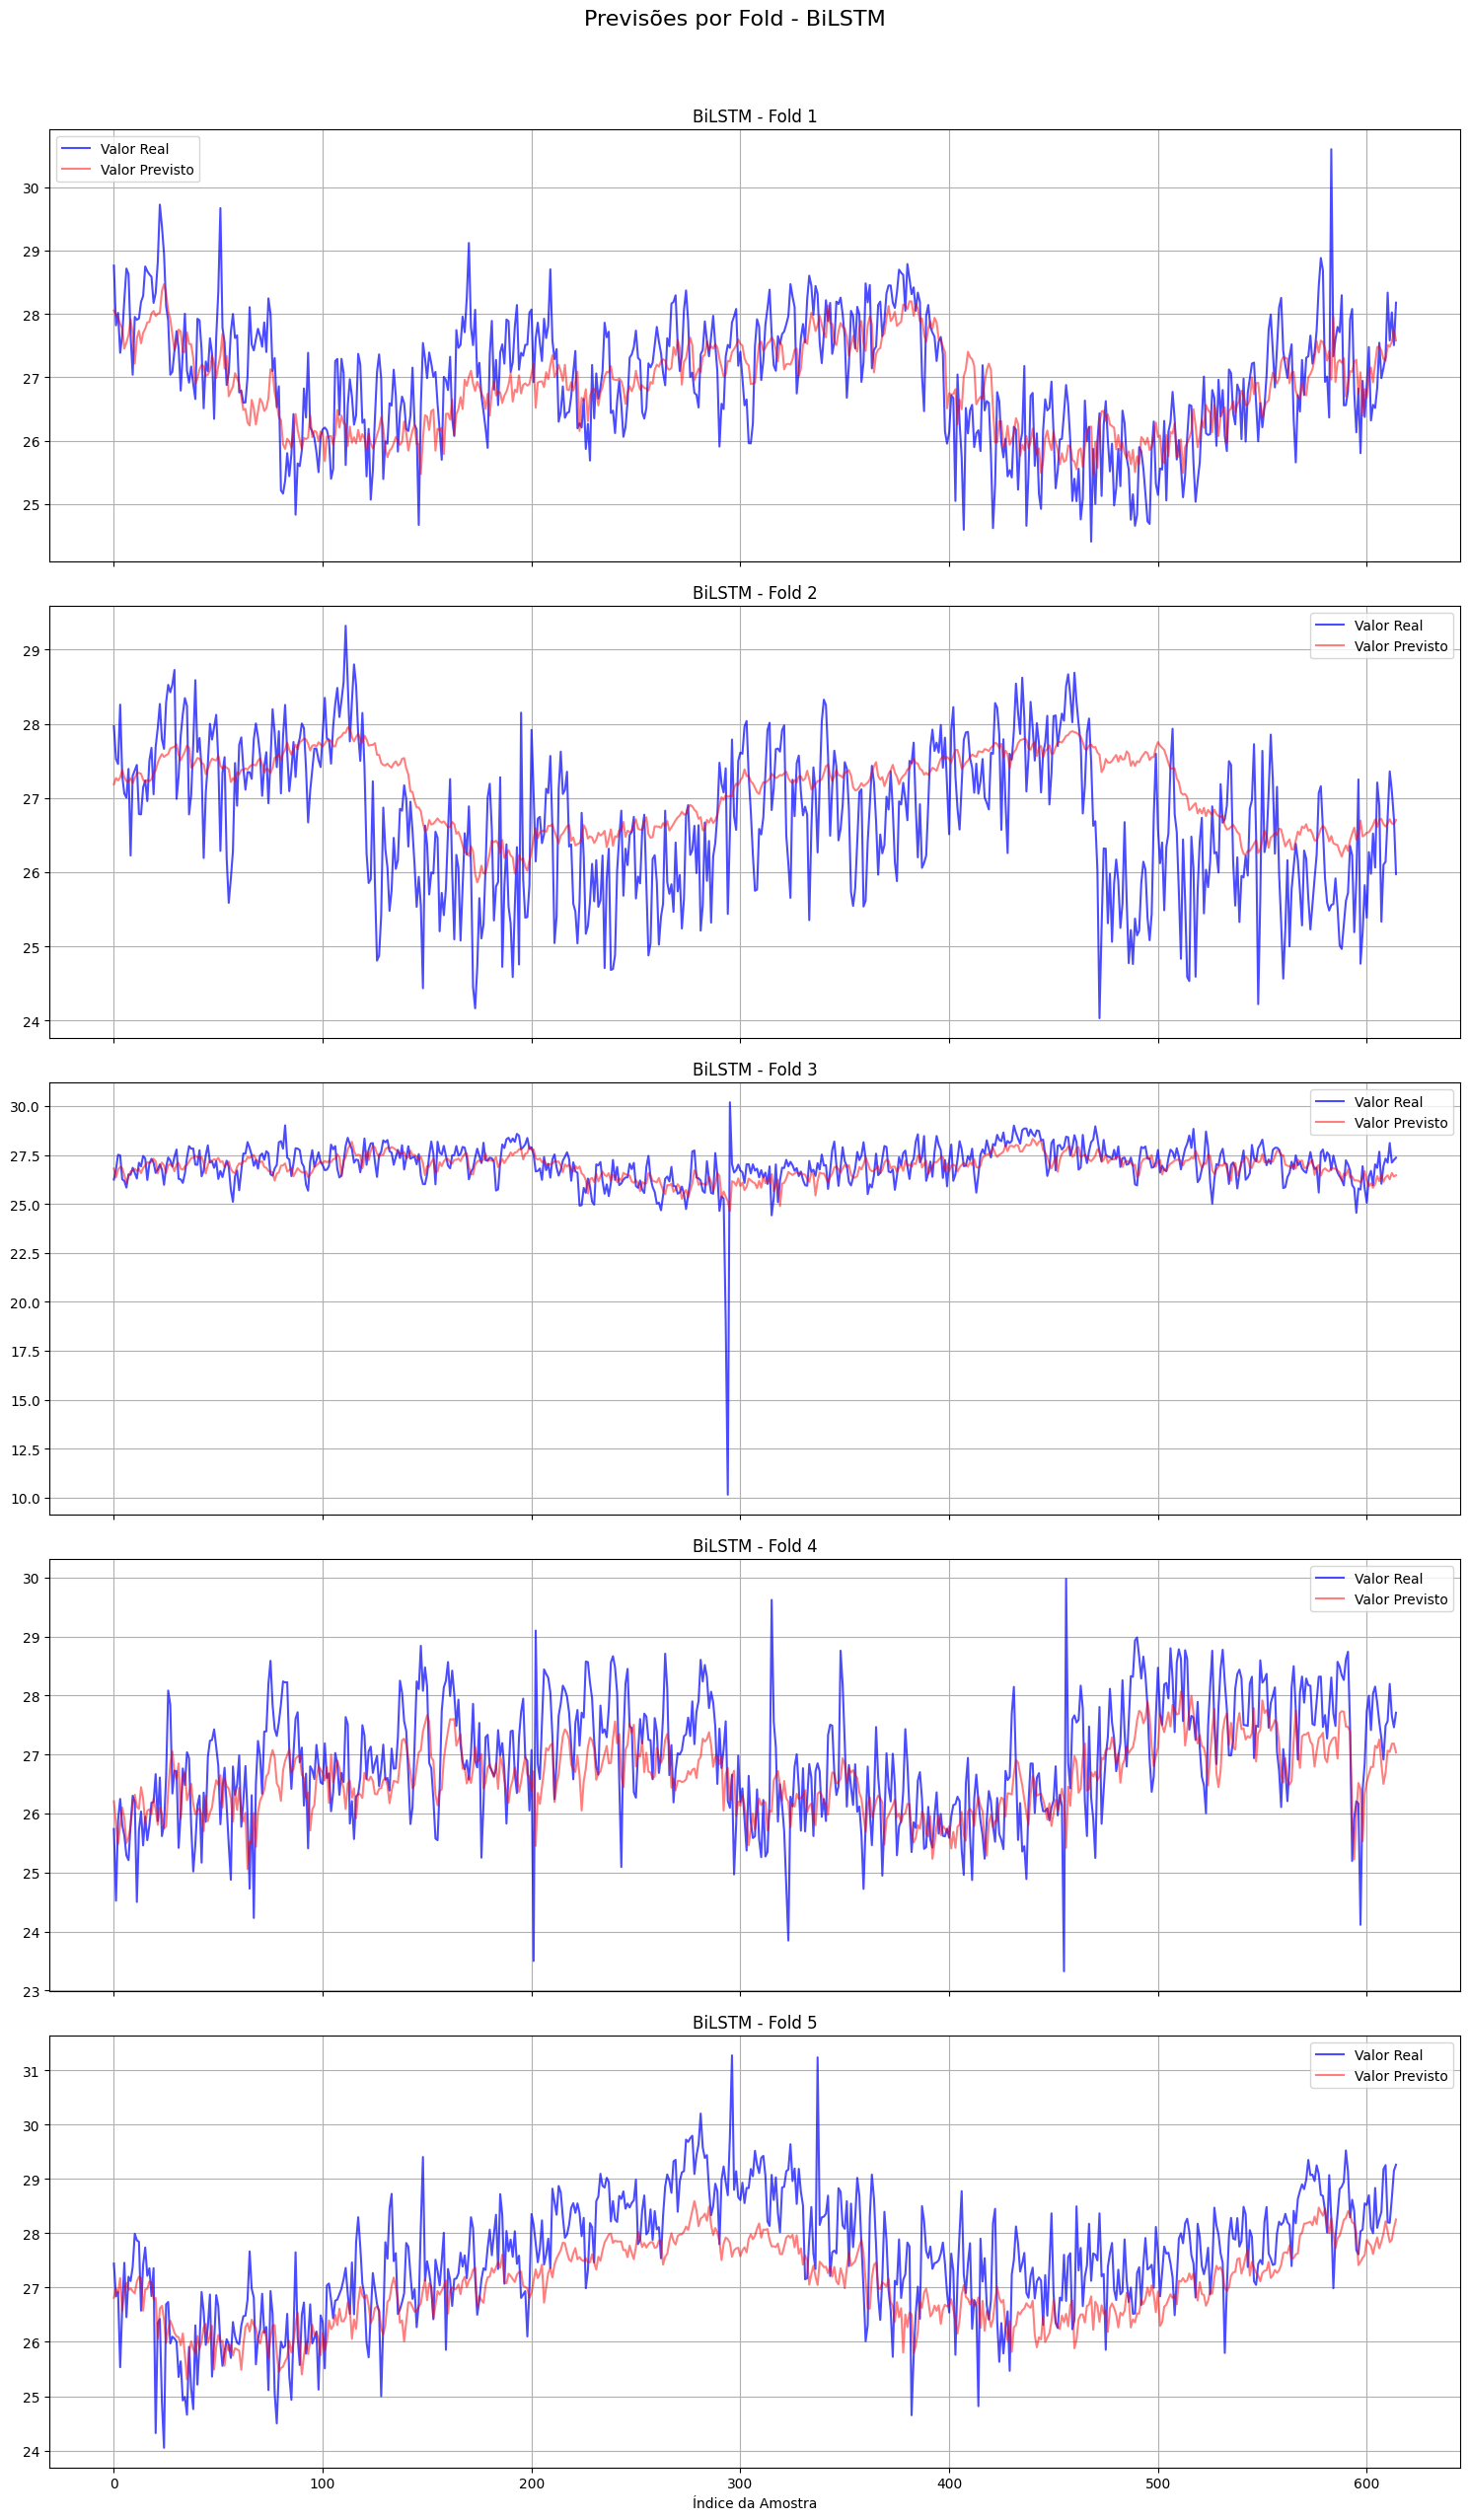

Gráfico salvo: results\BiLSTM_predictions.png


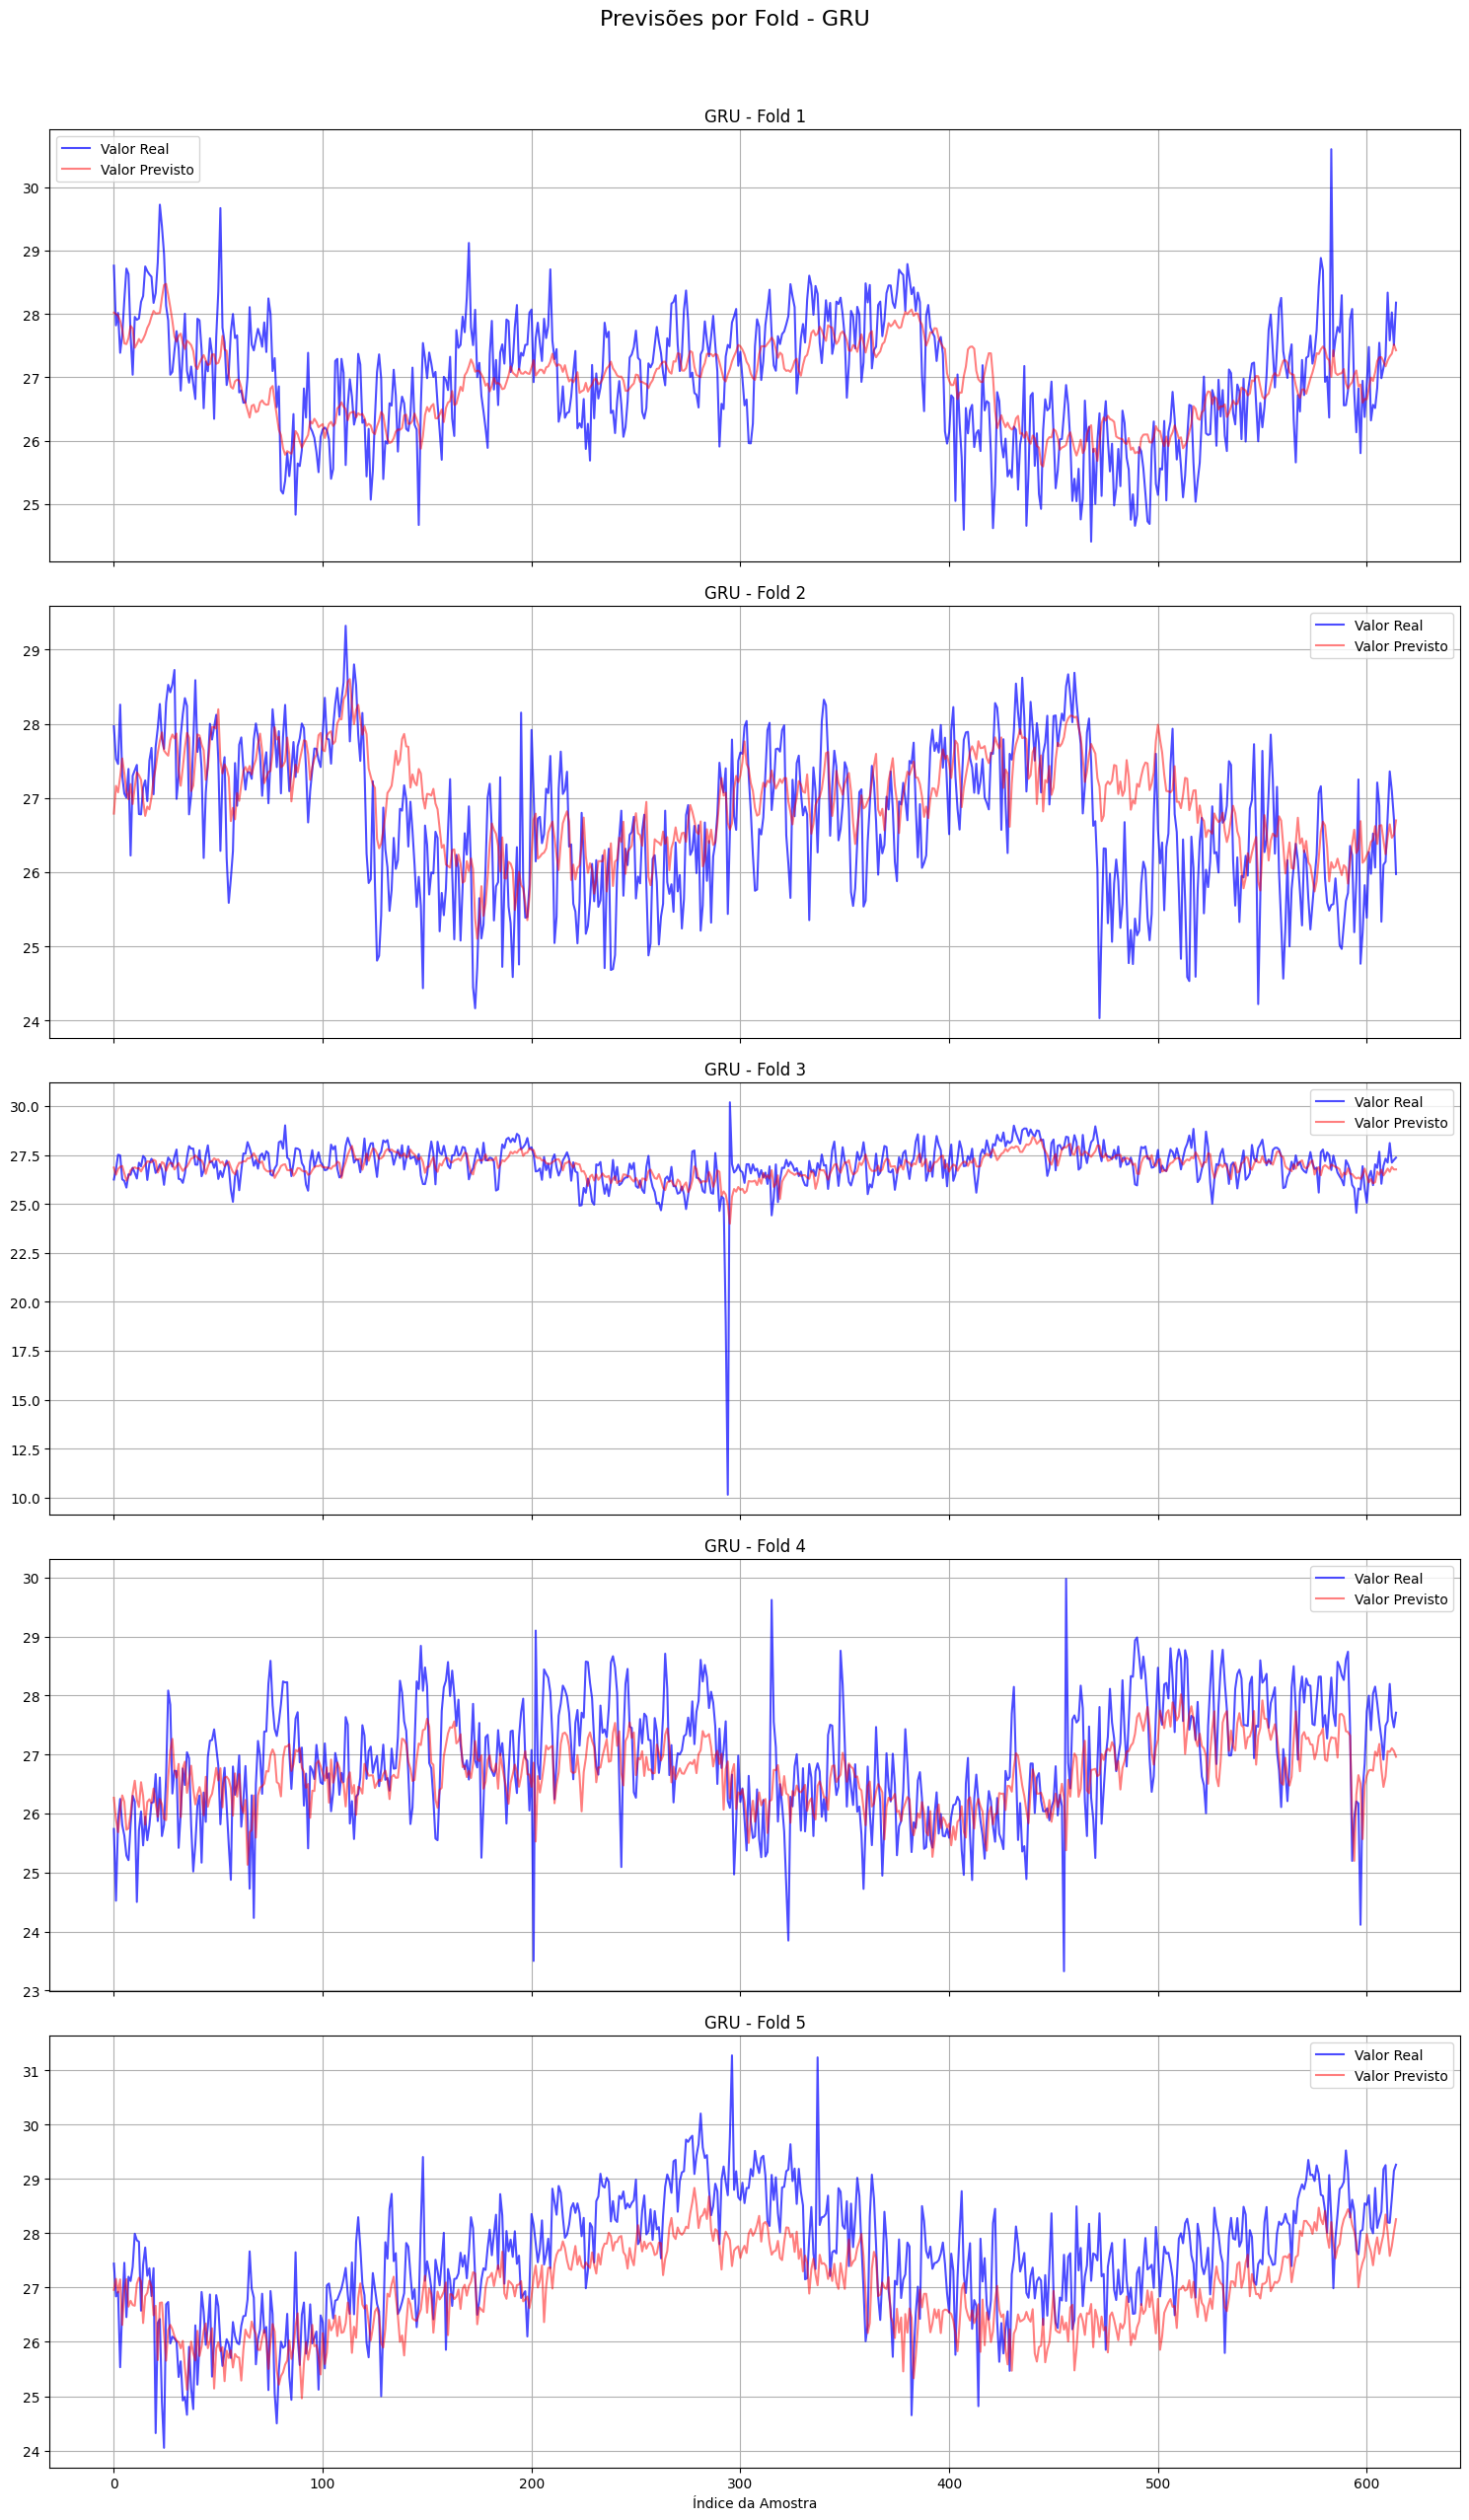

Gráfico salvo: results\GRU_predictions.png


In [49]:
# Previsões
for model_name, results in detailed_results.items():
    n_folds = len(results)
    fig, axes = plt.subplots(n_folds, 1, figsize=(15, 5 * n_folds), sharex=True)
    for i, fold_data in enumerate(results):
        y_true = fold_data['y_test']
        y_pred = fold_data['y_pred']
        
        # reverter a normalização
        y_true_original = target_scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
        y_pred_original = target_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
        
        axes[i].plot(y_true_original, label='Valor Real', color='blue', alpha=0.7)
        axes[i].plot(range(len(y_pred_original)), y_pred_original, label='Valor Previsto', color='red', alpha=0.5)
        axes[i].set_title(f'{model_name} - Fold {i+1}')
        axes[i].legend()
        axes[i].grid(True)

    plt.xlabel('Índice da Amostra')
    plt.suptitle(f'Previsões por Fold - {model_name}', fontsize=16, y=1.02)
    plt.tight_layout()
    filename = os.path.join(output_dir, f"{model_name}_predictions.png")
    plt.savefig(filename, dpi=300)
    plt.show()
    print(f"Gráfico salvo: {filename}")

In [51]:
from scipy.stats import friedmanchisquare

friedman_data = []
for model_name, model_results in detailed_results.items():
    friedman_data.append([fold_data['MSE'] for fold_data in model_results])

stat, p = friedmanchisquare(*friedman_data)
print(f"Friedman test: stat={stat:.4f}, p={p:.4f}")

Friedman test: stat=0.4000, p=0.8187


In [50]:
# salvando as previsões do últimos folds de cada modelo
for model_name, results in detailed_results.items():
    # Selecionar apenas o 5º fold
    fold_data = results[-1]  # Último fold (5º no caso)
    
    y_true = fold_data['y_test']
    y_pred = fold_data['y_pred']
    
    # Reverter a normalização
    y_true_original = target_scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
    y_pred_original = target_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    
    # Criar o gráfico
    plt.figure(figsize=(15, 5), dpi=300)
    plt.plot(y_true_original, label='Valor Real', color='blue', alpha=0.7)
    plt.plot(range(len(y_pred_original)), y_pred_original, label='Valor Previsto', color='red', alpha=0.5)
    plt.title(f'{model_name} - Fold 5')
    plt.xlabel('Índice da Amostra')
    plt.ylabel('Temperatura Média (°C)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    # Salvar o gráfico
    filename = os.path.join(output_dir, f"{model_name}_Fold_5_predictions.png")
    plt.savefig(filename, dpi=300)
    plt.close()  # Fecha a figura para evitar sobreposição
    
    print(f"Gráfico salvo: {filename}")


Gráfico salvo: results\LSTM_Fold_5_predictions.png
Gráfico salvo: results\BiLSTM_Fold_5_predictions.png
Gráfico salvo: results\GRU_Fold_5_predictions.png
